![alt text](https://esap.seas.upenn.edu/wp-content/themes/summer_engineering/media/seas_logo.png)

# Introduction

Welcome to our course project for CIS-5450 (Big Data Analytics)!

Our team consists of:

*   Ryan Abbate (MSE-DS, Spring 2023 cohort)
*   Paul Hamel (MCIT, Spring 2022 cohort)

<br>
For this project, we built machine learning models that predict a borrower's propensity to default on a loan. This notebook walks through our end-to-end process, which encompassed:

* data ingestion
* exploratory data analysis (EDA)
* data wrangling
* data cleaning
* machine learning modeling
* data visualization


# Motivation

Individuals with insufficient or non-existent credit histories often encounter challenges in securing loans.  Those fortunate enough to obtain loans may fall victim to unscrupulous lenders who impose exorbitant interest rates and unfavorable lending terms.

Lenders generally aim to optimize profits while minimizing potential risks.  Lenders that use *accurate* predictive models when assessing default risk among certain customer profiles are able to extend credit to borrowers who may not meet traditional lending standards.  This data-driven approach ensures that borrowers who are capable of loan repayment receive the capital that they need, which has a stimulative effect on economic activity.


# Data Source

For this project, we used loan repayment data from a Kaggle competition hosted by [Home Credit Group](https://www.homecredit.net/) in 2018.  Details about the competition may be found [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The data consists of several csv files totaling approximately 3GB in size.  

# Data Ingestion

To retrieve the data, we used Kaggle's public-facing API, which requires users to authenticate via an API token.  However, we found it more convenient (and faster) to save, then load the files locally.  The raw data files can be downloaded from [here](https://www.kaggle.com/competitions/home-credit-default-risk/data).

After downloading the raw data files, users need only change their working directory in the following cell to run our project locally.

In [332]:
# navigate to directory where data is stored

MY_WORKING_DIRECTORY = 'C:\\Users\\ryan\\Desktop\\Penn\\CIS_5450\\Project\\home-credit-default-risk'

os.chdir(MY_WORKING_DIRECTORY)

# Dependencies and Libraries

Let's begin by installing the required dependencies.


In [2]:
# install dependencies with silenced output
!pip install tqdm --quiet
!pip install xgboost --quiet

Next, we import the Python libraries that we'll use for this project.

In [3]:
# import the required libraries

# general
from tqdm.notebook import tqdm
import os


# data wrangling, cleaning and sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# model selection
from sklearn.model_selection import train_test_split

# models
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import BaggingClassifier

# model tuning
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# visualization
from matplotlib import colors
from matplotlib import lines
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import seaborn as sns


C:\Users\ryan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ryan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [5]:
# graph settings

mpl.rcParams['figure.figsize'] = [12,6]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.labelweight'] = 'normal'
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['font.family'] = 'Sans'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.color'] = 'lightgrey'
mpl.rcParams['xtick.color'] = 'lightgrey'
mpl.rcParams['text.color'] = 'lightgrey'
mpl.rcParams['axes.titlecolor'] = 'lightgrey'
mpl.rcParams['axes.labelcolor'] = 'lightgrey'
mpl.rcParams['axes.edgecolor'] = 'lightgrey'

mpl.rcParams['date.autoformatter.year'] = '%Y'
mpl.rcParams['date.autoformatter.month'] = '%b-%Y'
#change background color to transparent
mpl.rcParams['figure.facecolor'] = '#282c34'
#change plot foreground color to grey
mpl.rcParams['axes.facecolor'] = '#282c34'


#change default color cycler to ggplot
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D'])
mpl.rcParams['lines.linewidth'] = 2
colors = ['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D']


In [6]:
# ingest the data

d = {}

d['application_test_df'] = pd.read_csv('application_test.csv', encoding='latin-1')
d['application_train_df'] = pd.read_csv('application_train.csv', encoding='latin-1')
d['credit_card_balance_df'] = pd.read_csv('credit_card_balance.csv', encoding='latin-1')
d['previous_application_df'] = pd.read_csv('previous_application.csv', encoding='latin-1')

Since we stored the dataframes in a dictionary `d`, we access a given dataframe by its key.  Let's inspect the data.

In [7]:
# access dataframes via a dictionary such as d['application_train_df']
d['application_train_df'].head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# inspect all dataframes

for key, df in d.items():
  print(key)
  print('\n')
  print(df.head())
  print('\n')


application_test_df


   SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19

In [9]:
# cast all column headers to lowercase
for key, df in d.items():
  df.columns = df.columns.str.lower()


# Exploratory Data Analysis (EDA)

We start by exploring the basic characteristics of the various datasets.  For each dataframe, we call the `info()` method to display the data type and non-null counts.  We also call the `describe()` method to display the summary statistics.

In [10]:
for key, df in d.items():
  print(key)
  df.info(verbose = True, show_counts = True)
  print('-' * 72)

application_test_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    sk_id_curr                    48744 non-null  int64  
 1    name_contract_type            48744 non-null  object 
 2    code_gender                   48744 non-null  object 
 3    flag_own_car                  48744 non-null  object 
 4    flag_own_realty               48744 non-null  object 
 5    cnt_children                  48744 non-null  int64  
 6    amt_income_total              48744 non-null  float64
 7    amt_credit                    48744 non-null  float64
 8    amt_annuity                   48720 non-null  float64
 9    amt_goods_price               48744 non-null  float64
 10   name_type_suite               47833 non-null  object 
 11   name_income_type              48744 non-null  object 
 12   name_education_type     

For each dataframe, let's check the percent of missing values for each attribute.

In [11]:
for key, df in d.items():
  print(key)
  percent_missing = df.isnull().sum() * 100 / len(df)
  missing_values_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing}) \
                                .sort_values(by = ['percent_missing'], ascending = False).round(2)
  print(missing_values_df)
  print('-' * 72)




application_test_df
                                       column_name  percent_missing
commonarea_avg                      commonarea_avg            68.72
commonarea_mode                    commonarea_mode            68.72
commonarea_medi                    commonarea_medi            68.72
nonlivingapartments_avg    nonlivingapartments_avg            68.41
nonlivingapartments_mode  nonlivingapartments_mode            68.41
...                                            ...              ...
name_housing_type                name_housing_type             0.00
name_family_status              name_family_status             0.00
name_education_type            name_education_type             0.00
name_income_type                  name_income_type             0.00
sk_id_curr                              sk_id_curr             0.00

[121 rows x 2 columns]
------------------------------------------------------------------------
application_train_df
                                       column_

We immediately notice that there is a **large** amount of missing data.

The `sk_id_curr` attribute is the primary key of the `application_{test | train}_df` relations.  The following relations have `sk_id_curr` as a foreign key:

*   `previous_application_df`
*   `credit_card_balance_df`

We will join the `application_{test | train}_df` relations to these two relations.

The `sk_id_prev` attribute is the primary key of the `previous_application_df` relation.  The following relation has `sk_id_prev` as a foreign key:

*   `credit_card_balance_df`

In [12]:
train_ids = d['application_train_df']['sk_id_curr'].unique()

# Credit Card Balance
cc_pct = len(np.intersect1d(d['credit_card_balance_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
print('Credit Card Balance: {:.2%}'.format(cc_pct))

# Previous Application
prev_app_pct = len(np.intersect1d(d['previous_application_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Previous Application: {:.2%}'.format(prev_app_pct))



Credit Card Balance: 28.26%
Previous Application: 94.65%


Let's check for duplication.

In [13]:
for key, df in d.items():
  print('Dataframe:', key)
  print(df.nunique())
  print('-' * 72)

Dataframe: application_test_df
sk_id_curr                    48744
name_contract_type                2
code_gender                       2
flag_own_car                      2
flag_own_realty                   2
                              ...  
amt_req_credit_bureau_day         3
amt_req_credit_bureau_week        3
amt_req_credit_bureau_mon         7
amt_req_credit_bureau_qrt         8
amt_req_credit_bureau_year       16
Length: 121, dtype: int64
------------------------------------------------------------------------
Dataframe: application_train_df
sk_id_curr                    307511
target                             2
name_contract_type                 2
code_gender                        3
flag_own_car                       2
                               ...  
amt_req_credit_bureau_day          9
amt_req_credit_bureau_week         9
amt_req_credit_bureau_mon         24
amt_req_credit_bureau_qrt         11
amt_req_credit_bureau_year        25
Length: 122, dtype: int64
---------

In [14]:
# get summary statistics of each dataset

for key, df in d.items():
  print(key)
  print(df.describe(include = np.number).T)
  print('-' * 72)

application_test_df
                              count           mean            std       min  \
sk_id_curr                  48744.0  277796.676350  103169.547296  100001.0   
cnt_children                48744.0       0.397054       0.709047       0.0   
amt_income_total            48744.0  178431.805855  101522.591536   26941.5   
amt_credit                  48744.0  516740.435561  365397.004174   45000.0   
amt_annuity                 48720.0   29426.240209   16016.368315    2295.0   
...                             ...            ...            ...       ...   
amt_req_credit_bureau_day   42695.0       0.001803       0.046132       0.0   
amt_req_credit_bureau_week  42695.0       0.002787       0.054037       0.0   
amt_req_credit_bureau_mon   42695.0       0.009299       0.110924       0.0   
amt_req_credit_bureau_qrt   42695.0       0.546902       0.693305       0.0   
amt_req_credit_bureau_year  42695.0       1.983769       1.838873       0.0   

                               

## Distrubtion of Target Variable

Let's examine the distribution of the target variable in our training dataset.

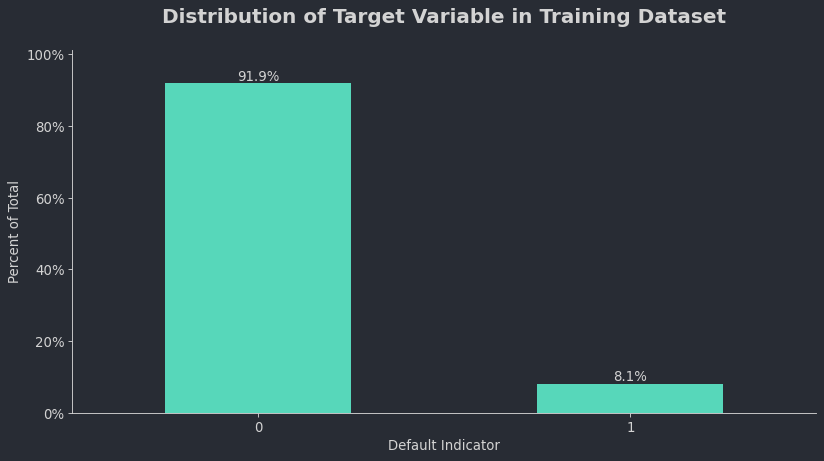

In [15]:
# plot the distribution of the Target Variable in the training dataset

ax = (d['application_train_df']['target'].value_counts() * 100/len(d['application_train_df'])).plot(kind = 'bar')

plt.title('Distribution of Target Variable in Training Dataset')
plt.xlabel('Default Indicator')
plt.ylabel('Percent of Total')
plt.xticks(rotation = 'horizontal')

ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.1f%%')
ax.margins(y = 0.1)

#make y axis percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

The training data consists primarily of loans that have not defaulted.  The classes are highly unbalanced, which could affect our modeling.  Therefore, in a later step, we must oversample or undersample to compensate for this unbalanced data.

# Correlation Analysis
Now, we'll generate a correlation matrix on the training dataset to check for correlation among the features.

In [20]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

corr = d['application_train_df'].corr(numeric_only = True)
corr


,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,totalarea_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
sk_id_curr,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000849,-0.001500,0.001366,-0.000973,-0.000384,0.001818,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.002895,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.000082,0.002342,0.000222,0.001556,-0.002070,0.001551,0.005900,-0.001463,0.004862,-0.002879,0.004851,0.003083,0.001465,0.003119,0.001770,-0.002575,0.003042,0.001961,-0.001411,0.001890,0.005245,-0.001058,0.005017,-0.002844,0.004386,0.002081,0.001548,0.003589,0.002156,-0.001923,0.001920,0.001988,-0.001647,0.001366,0.005777,-0.001036,0.005067,-0.002583,0.004588,0.002837,0.001699,0.003272,0.002205,-0.003020,0.002440,0.002288,-0.001409,-0.000082,-0.001423,0.001187,-0.000858,0.000700,-0.003411,-0.004139,-0.001097,0.002121,-0.002694,0.001809,0.001505,-0.000815,-0.002012,-0.001045,0.000896,-0.001077,0.002604,-0.000724,0.001450,0.000509,0.000167,0.001073,0.000282,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659
target,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,0.051457,0.037612,0.000534,0.045982,0.028524,0.000370,-0.023806,-0.001758,0.009308,0.058899,0.060893,-0.024166,0.005576,0.006942,0.002819,0.044395,0.050994,0.032518,-0.155317,-0.160472,-0.178919,-0.029498,-0.022746,-0.009728,-0.022149,-0.018550,-0.034199,-0.019172,-0.044003,-0.033614,-0.010885,-0.025031,-0.032997,-0.003176,-0.013578,-0.027284,-0.019952,-0.009036,-0.022068,-0.016340,-0.032131,-0.017387,-0.043226,-0.032698,-0.010174,-0.023393,-0.030685,-0.001557,-0.012711,-0.029184,-0.022081,-0.009993,-0.022326,-0.018573,-0.033863,-0.019025,-0.043768,-0.033394,-0.011256,-0.024621,-0.032739,-0.002757,-0.013337,-0.032596,0.009131,0.032248,0.009022,0.031276,0.055218,0.005417,0.044346,-0.002672,-0.000316,-0.028602,-0.001520,-0.008040,-0.004352,-0.001414,-0.004229,-0.000756,-0.011583,-0.009464,-0.006536,-0.011615,-0.003378,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
cnt_children,-0.001129,0.019187,1.0000

Given the size of this correlation matrix, let's set a threshold and view only the features that have correlation greater than a certain threshold.

In [21]:
# define a threshold
correlation_threshold = 0.7

# get a list of pair-wise features that exceed this threshold
high_correlation_pairs = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > correlation_threshold:
            high_correlation_pairs.append((corr.columns[i], corr.columns[j]))


high_correlation_pairs


[('cnt_children', 'cnt_fam_members'),
 ('amt_credit', 'amt_annuity'),
 ('amt_credit', 'amt_goods_price'),
 ('amt_annuity', 'amt_goods_price'),
 ('days_employed', 'flag_emp_phone'),
 ('region_rating_client', 'region_rating_client_w_city'),
 ('reg_region_not_work_region', 'live_region_not_work_region'),
 ('reg_city_not_work_city', 'live_city_not_work_city'),
 ('apartments_avg', 'elevators_avg'),
 ('apartments_avg', 'livingapartments_avg'),
 ('apartments_avg', 'livingarea_avg'),
 ('apartments_avg', 'apartments_mode'),
 ('apartments_avg', 'elevators_mode'),
 ('apartments_avg', 'livingapartments_mode'),
 ('apartments_avg', 'livingarea_mode'),
 ('apartments_avg', 'apartments_medi'),
 ('apartments_avg', 'elevators_medi'),
 ('apartments_avg', 'livingapartments_medi'),
 ('apartments_avg', 'livingarea_medi'),
 ('apartments_avg', 'totalarea_mode'),
 ('basementarea_avg', 'basementarea_mode'),
 ('basementarea_avg', 'basementarea_medi'),
 ('years_beginexpluatation_avg', 'years_beginexpluatation_mode

In [22]:
print(f'There are {len(high_correlation_pairs)} that exhibit correlation greater than {correlation_threshold}.')

There are 127 that exhibit correlation greater than 0.7.


In [341]:
# create a heatmap of only the high correlation pairs

high_correlation_features = list()

for pair in high_correlation_pairs:
    high_correlation_features.extend(pair)

high_correlation_matrix = corr.loc[high_correlation_features, high_correlation_features]
high_correlation_matrix
#high_correlation_matrix.style.background_gradient(cmap = 'coolwarm').format(precision=2)



,cnt_children,cnt_fam_members,amt_credit,amt_annuity,amt_credit,amt_goods_price,amt_annuity,amt_goods_price,days_employed,flag_emp_phone,region_rating_client,region_rating_client_w_city,reg_region_not_work_region,live_region_not_work_region,reg_city_not_work_city,live_city_not_work_city,apartments_avg,elevators_avg,apartments_avg,livingapartments_avg,apartments_avg,livingarea_avg,apartments_avg,apartments_mode,apartments_avg,elevators_mode,apartments_avg,livingapartments_mode,apartments_avg,livingarea_mode,apartments_avg,apartments_medi,apartments_avg,elevators_medi,apartments_avg,livingapartments_medi,apartments_avg,livingarea_medi,apartments_avg,totalarea_mode,basementarea_avg,basementarea_mode,basementarea_avg,basementarea_medi,years_beginexpluatation_avg,years_beginexpluatation_mode,years_beginexpluatation_avg,years_beginexpluatation_medi,years_build_avg,years_build_mode,years_build_avg,years_build_medi,commonarea_avg,commonarea_mode,commonarea_avg,commonarea_medi,elevators_avg,livingapartments_avg,elevators_avg,livingarea_avg,elevators_avg,apartments_mode,elevators_avg,elevators_mode,elevators_avg,livingapartments_mode,elevators_avg,livingarea_mode,elevators_avg,apartments_medi,elevators_avg,elevators_medi,elevators_avg,livingapartments_medi,elevators_avg,livingarea_medi,elevators_avg,totalarea_mode,entrances_avg,entrances_mode,entrances_avg,entrances_medi,floorsmax_avg,floorsmin_avg,floorsmax_avg,floorsmax_mode,floorsmax_avg,floorsmin_mode,floorsmax_avg,floorsmax_medi,floorsmax_avg,floorsmin_medi,floorsmin_avg,floorsmax_mode,floorsmin_avg,floorsmin_mode,floorsmin_avg,floorsmax_medi,floorsmin_avg,floorsmin_medi,...,apartments_mode,livingarea_mode,apartments_mode,apartments_medi,apartments_mode,elevators_medi,apartments_mode,livingapartments_medi,apartments_mode,livingarea_medi,apartments_mode,totalarea_mode,basementarea_mode,basementarea_medi,years_beginexpluatation_mode,years_beginexpluatation_medi,years_build_mode,years_build_medi,commonarea_mode,commonarea_medi,elevators_mode,livingapartments_mode,elevators_mode,livingarea_mode,elevators_mode,apartments_medi,elevators_mode,elevators_medi,elevators_mode,livingapartments_medi,elevators_mode,livingarea_medi,elevators_mode,totalarea_mode,entrances_mode,entrances_medi,floorsmax_mode,floorsmin_mode,floorsmax_mode,floorsmax_medi,floorsmax_mode,floorsmin_medi,floorsmin_mode,floorsmax_medi,floorsmin_mode,floorsmin_medi,landarea_mode,landarea_medi,livingapartments_mode,livingarea_mode,livingapartments_mode,apartments_medi,livingapartments_mode,elevators_medi,livingapartments_mode,livingapartments_medi,livingapartments_mode,livingarea_medi,livingapartments_mode,totalarea_mode,livingarea_mode,apartments_medi,livingarea_mode,elevators_medi,livingarea_mode,livingapartments_medi,livingarea_mode,livingarea_medi,livingarea_mode,totalarea_mode,nonlivingapartments_mode,nonlivingapartments_medi,nonlivingarea_mode,nonlivingarea_medi,apartments_medi,elevators_medi,apartments_medi,livingapartments_medi,apartments_medi,livingarea_medi,apartments_medi,totalarea_mode,elevators_medi,livingapartments_medi,elevators_medi,livingarea_medi,elevators_medi,totalarea_mode,floorsmax_medi,floorsmin_medi,livingapartments_medi,livingarea_medi,livingapartments_medi,totalarea_mode,livingarea_medi,totalarea_mode,obs_30_cnt_social_circle,obs_60_cnt_social_circle,def_30_cnt_social_circle,def_60_cnt_social_circle
cnt_children,1.000000,0.879161,0.002145,0.021374,0.002145,-0.001827,0.021374,-0.001827,-0.239818,0.240714,0.025423,0.024781,0.008185,0.014835,0.070650,0.069957,-0.013222,-0.007060,-0.013222,-0.008648,-0.013222,-0.010116,-0.013222,-0.012105,-0.013222,-0.006397,-0.013222,-0.007955,-0.013222,-0.009517,-0.013222,-0.012985,-0.013222,-0.006747,-0.013222,-0.007962,-0.013222,-0.010067,-0.013222,-0.008037,-0.008464,-0.008513,-0.008464,-0.008799,0.006902,0.006199,0.006902,0.006401,0.030172,0.029549,0.030172,0.030124,0.000140,0.000440,0.000140,0.000609,-0.007060,-0.008648,-0.007060,-0.010116,-0.007060,-0.012105,-0.

## Housing Variables

Many of the highly correlated features are housing variables, which describe the characteristics of a borrower's current living situation. We will reduce the dimensionality of these features by creating PCA variables on these `housing variables` so that we may use them in our modeling. We will then fit a simple logistic regression to see if there is any predictability of using these outright to see if these variables have any predictability on their own.

Due to the high prevalence of null values in these, we fit the PCA and explore the model with the rows that have no nulls in any of them (~25%), and then fill all missing values with the mean of that respective column before transforming the variables of the main dataframes (train/test).

In [25]:
housing_variables = [ 'apartments_avg',
                      'basementarea_avg',
                      'years_beginexpluatation_avg',
                      'years_build_avg',
                      'commonarea_avg',
                      'elevators_avg',
                      'entrances_avg',
                      'floorsmax_avg',
                      'floorsmin_avg',
                      'landarea_avg',
                      'livingapartments_avg',
                      'livingarea_avg',
                      'nonlivingapartments_avg',
                      'nonlivingarea_avg',
                      'apartments_mode',
                      'basementarea_mode',
                      'years_beginexpluatation_mode',
                      'years_build_mode',
                      'commonarea_mode',
                      'elevators_mode',
                      'entrances_mode',
                      'floorsmax_mode',
                      'floorsmin_mode',
                      'landarea_mode',
                      'livingapartments_mode',
                      'livingarea_mode',
                      'nonlivingapartments_mode',
                      'nonlivingarea_mode',
                      'apartments_medi',
                      'basementarea_medi',
                      'years_beginexpluatation_medi',
                      'years_build_medi',
                      'commonarea_medi',
                      'elevators_medi',
                      'entrances_medi',
                      'floorsmax_medi',
                      'floorsmin_medi',
                      'landarea_medi',
                      'livingapartments_medi',
                      'livingarea_medi',
                      'nonlivingapartments_medi',
                      'nonlivingarea_medi',
                      'housetype_mode',
                      'totalarea_mode',
                      'wallsmaterial_mode',
                      'emergencystate_mode'
                    ]

In [26]:
print("Percent of rows with valid data for all housing variables: {:.2%}".format((d['application_train_df'][housing_variables].isna().sum(axis = 1) == 0).astype(int).sum() / len(d['application_train_df'])))


Percent of rows with valid data for all housing variables: 26.49%


Due to the lack of variability for the `emergencystate_mode` and `housetype_mode` features, we will drop them from the dataset.

In [27]:
d['application_train_df']['housetype_mode'].value_counts()

housetype_mode
block of flats      150503
specific housing      1499
terraced house        1212
Name: count, dtype: int64

In [28]:
d['application_train_df']['emergencystate_mode'].value_counts()

emergencystate_mode
No     159428
Yes      2328
Name: count, dtype: int64

In [29]:

housing_variables.remove('housetype_mode')
housing_variables.remove('emergencystate_mode')

d['application_train_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)
d['application_test_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)

There are only 2 prevalent `wallsmaterial_mode` values, but they have some differentiation in default rates, so we will retain this feature. We will one-hot encode this feature and consider converting all values that are not "Panel" or "Stone, brick" as "Others". All null values for this attribute will be populated as "Others"

In [30]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target').reset_index()


,wallsmaterial_mode,target,sk_id_curr
0,Monolithic,0.047218,1779
1,Panel,0.063477,66040
2,Block,0.070247,9253
3,"Stone, brick",0.074057,64815
4,Mixed,0.075348,2296
5,Others,0.083077,1625
6,Wooden,0.096979,5362


In [31]:
#There are only 27 rows that have valid data for all housing variables (except wallsmaterial_mode),
#so fitting the PCA while one-hot encoding the `wallsmaterial_mode` variable will not be feasible.

d['application_train_df'].dropna(subset = [x for x in housing_variables if x != 'wallsmaterial_mode'])['wallsmaterial_mode'].isna().sum()


27

In [32]:
d['application_train_df'].loc[~d['application_train_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'


In [33]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target')


,target,sk_id_curr
wallsmaterial_mode,,
Panel,0.063477,66040
"Stone, brick",0.074057,64815
Other,0.089626,176656


In [34]:
d['application_train_df'] = pd.get_dummies(d['application_train_df'], columns = ['wallsmaterial_mode'])
d['application_test_df'] = pd.get_dummies(d['application_test_df'], columns = ['wallsmaterial_mode'])

wall_material_cols = [x for x in d['application_train_df'].columns if 'wallsmaterial_mode_' in x]

d['application_train_df'][wall_material_cols] = d['application_train_df'][wall_material_cols].astype(int)
d['application_test_df'][wall_material_cols] = d['application_test_df'][wall_material_cols].astype(int)

#remove trhe wallsmaterial_mode column from the housing variables list and append the new one-hot `encodedwallsmaterial_mode` columns
housing_variables.remove('wallsmaterial_mode')
housing_variables.extend(wall_material_cols)


In [35]:
#getting a subset with only the rows that have valid data for all housing variables
app_train_housing = d['application_train_df'].dropna(subset=housing_variables).copy()


In [36]:
app_train_housing[housing_variables] = StandardScaler().fit_transform(app_train_housing[housing_variables])
pca = PCA(n_components = len(housing_variables))
pca.fit(app_train_housing[housing_variables])
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

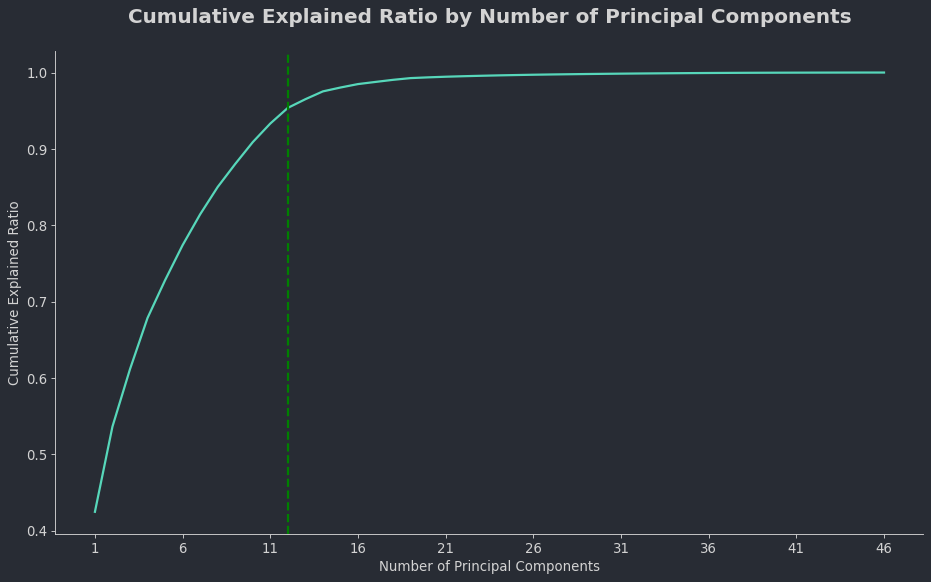

In [37]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.plot(cum_evr)
ax.set_xticks(np.arange(0, len(housing_variables), 5))
ax.set_xticklabels(np.arange(0, len(housing_variables), 5) + 1, rotation = 0)

ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Ratio')
ax.set_title('Cumulative Explained Ratio by Number of Principal Components')

#Vertical Line here at 11 really means 12 components
ax.axvline(11, linestyle = '--', color='green')

plt.show()

In [38]:
"{:.2%}".format(cum_evr[11]) #note that 11 is the 12th component

'95.37%'

A PCA with **12 principal components** allows us to capture 95% of the variability within the housing variables.

In [39]:
pca = PCA(n_components = 12)
pca.fit(app_train_housing[housing_variables])

PCA(n_components=12)

In [40]:
app_train_housing = pd.concat([app_train_housing,pd.DataFrame(pca.transform(app_train_housing[housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = app_train_housing.index)],axis = 1)


In [41]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(app_train_housing[['housing_pca_' + str(x) for x in range(1,13)]],app_train_housing['target'], test_size = 0.3, random_state = seed)


In [42]:
#Note that we must oversample or undersample to account for the imbalance in the target variable. We will use oversampling here.
d['application_train_df'].target.value_counts()


target
0    282686
1     24825
Name: count, dtype: int64

In [43]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)


In [44]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))

53.60%


While not a huge boost to predictability, we see a 53.6% accuracy score with solely the housing PCA components.  Therefore, we will keep these features and our model may or may not select them. We will fill in the missing values and perform the modeling again to ensure we get consistent results after filling in null values. Many rows have some of the housing variables, with some (or many) being null.

In [45]:
for col in housing_variables:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


In [46]:
#PCA on train and test after filling nulls. Using the PCA fit on the subset that had no null values
d['application_train_df'] = pd.concat([d['application_train_df'],pd.DataFrame(pca.transform(d['application_train_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_train_df'].index)],axis = 1)
d['application_test_df'] = pd.concat([d['application_test_df'],pd.DataFrame(pca.transform(d['application_test_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_test_df'].index)],axis = 1)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'][['housing_pca_' + str(x) for x in range(1,13)]],d['application_train_df']['target'], test_size = 0.3, random_state = seed)
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)


In [48]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))


53.79%


The predictability remained consistent after populating the `null` values with the mean.

In [49]:
#Drop the housing variables that are not the PCA components
d['application_train_df'].drop(columns = housing_variables,inplace=True)
d['application_test_df'].drop(columns = housing_variables,inplace=True)


Now, let's plot the distribution of the categorical variables using `sns.countplot()`.

In [50]:
# gets the columns that have categorical variables

object_columns = d['application_train_df'].select_dtypes(include=['object']).columns.tolist()
object_columns


['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'fondkapremont_mode']

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

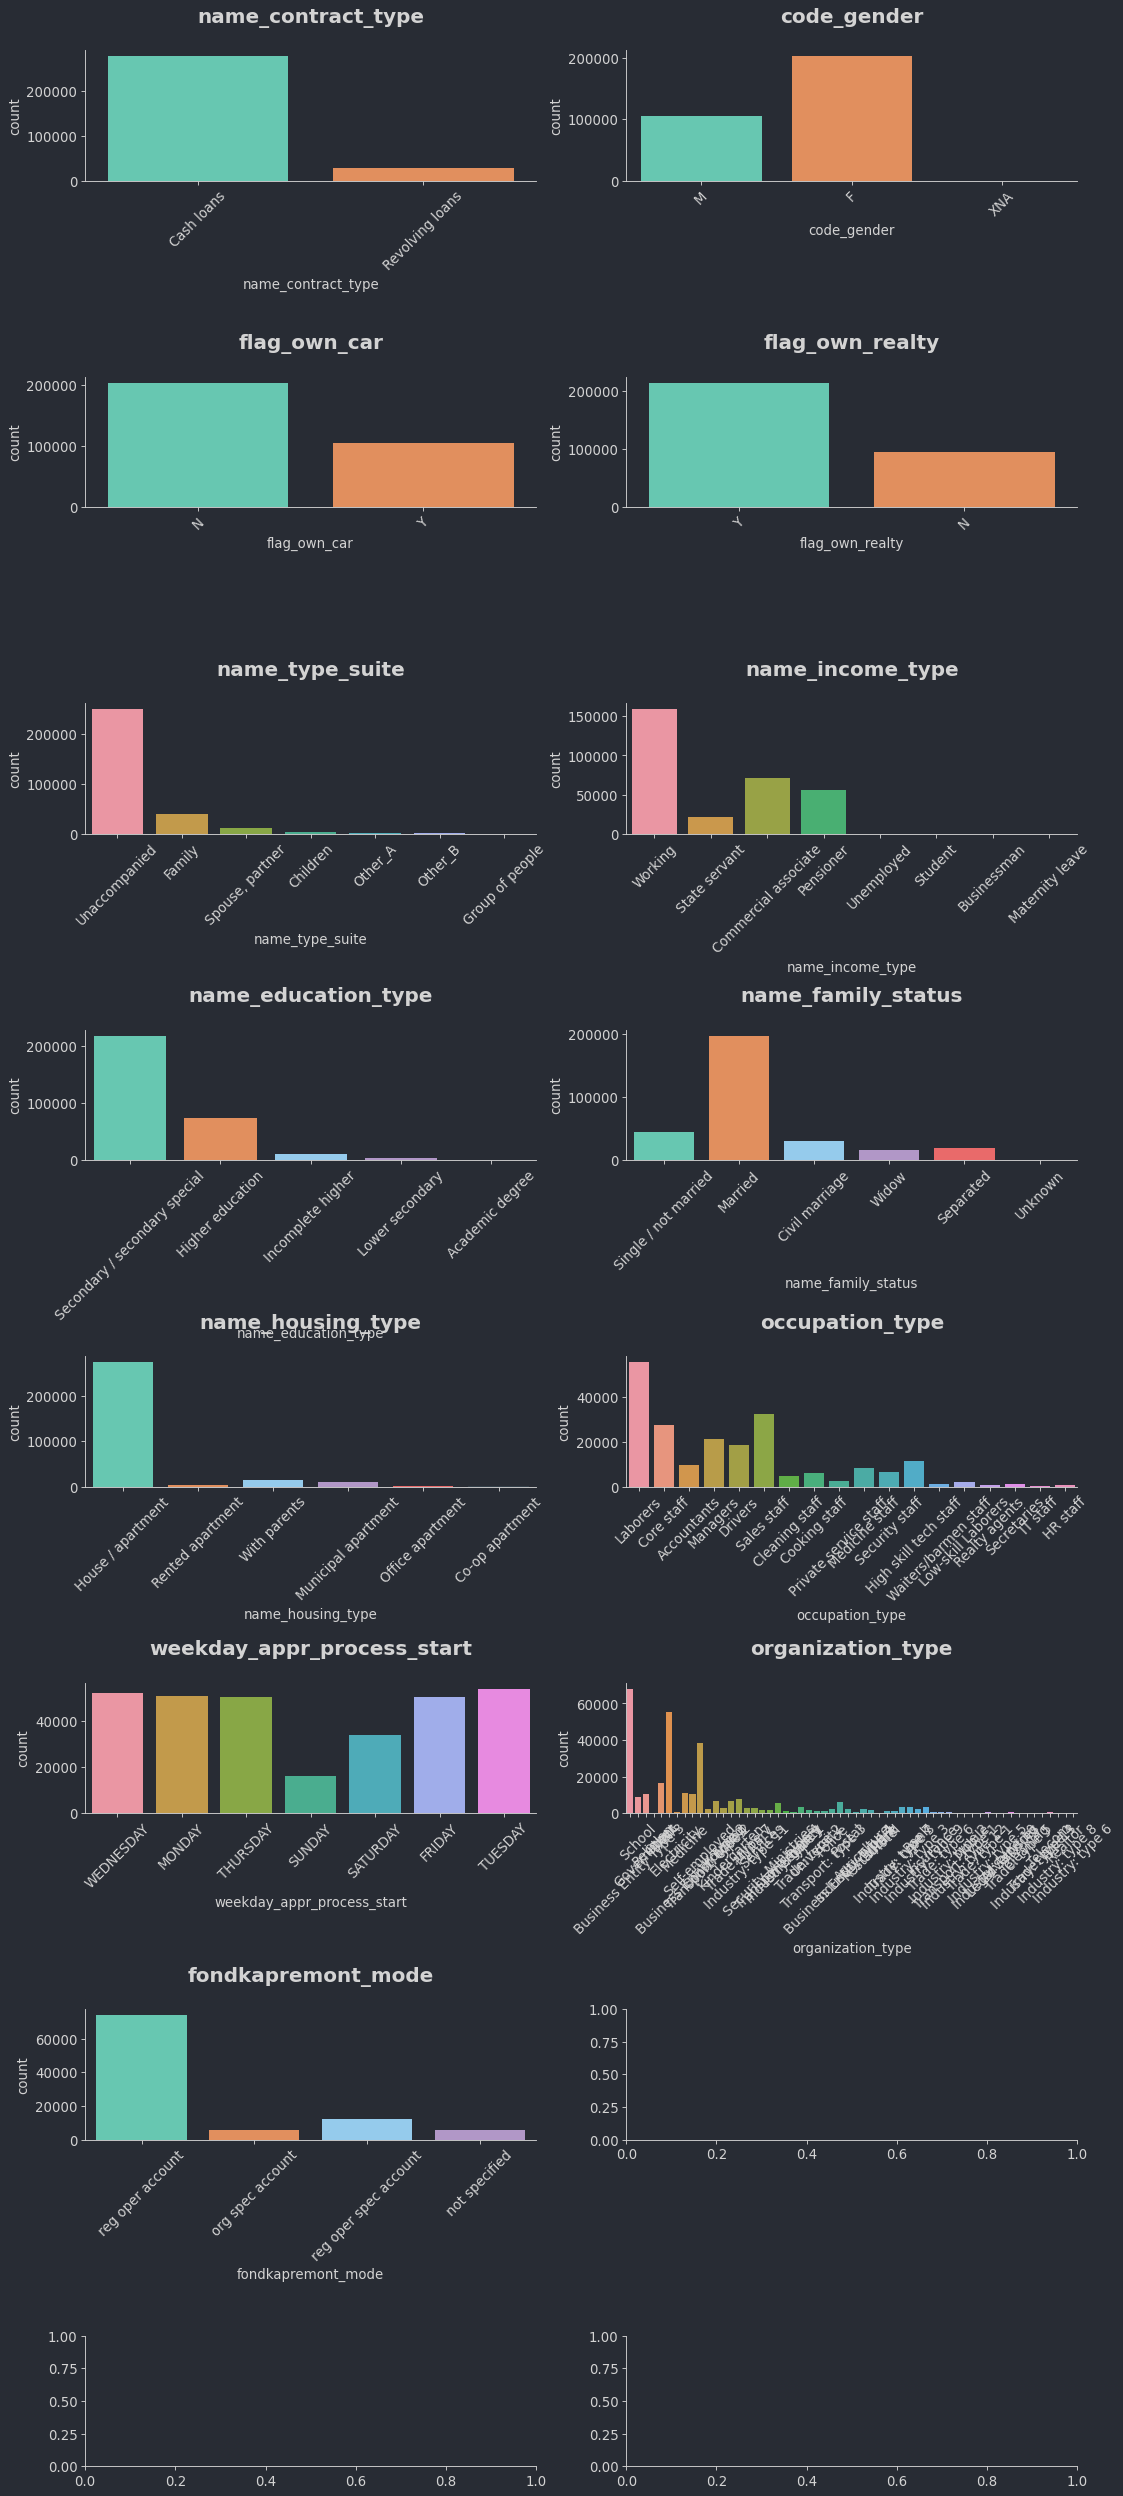

In [51]:
# plot the categorical variables

# define height ratios for the subplots
height_ratios = [50] * 7 + [50]

# create an 8x2 subplot grid
fig, axes = plt.subplots(8, 2, figsize=(16, 40), gridspec_kw={'height_ratios': height_ratios})

plt.subplots_adjust(hspace = 1.5)

# flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(object_columns):
    sns.countplot(x = column, data = d['application_train_df'], ax = axes[i])
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)

#plt.tight_layout(h_pad = 2.5)
plt.show()

In [52]:
# initial impressions
# predominent:  married females with a secondary education who own a home (but don't own a car) applying for cash loans

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


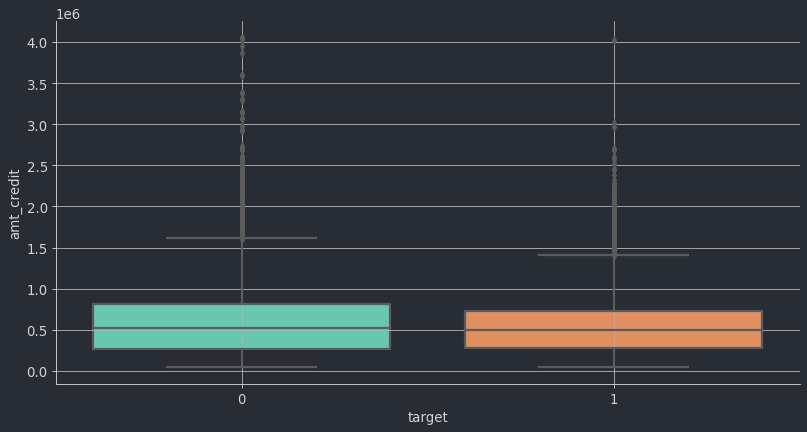

In [53]:
# Does a large amount of credit result in a default condition?  No!

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'amt_credit')
plt.grid()
plt.show()

In [54]:
# Is there a greater incidence of default among male borrowers?  Yes! (about 300 basis points greater than for female borrowers)

gender_target_counts = d['application_train_df'].groupby(['code_gender', 'target']).size()

gender_target_counts_unstacked = gender_target_counts.unstack('target')

percentage_defaults_by_gender = gender_target_counts_unstacked.div(gender_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#Changing gender to a binary variable with 1 = Female, 0 Otherwise
d['application_train_df']['code_gender']  = np.where(d['application_train_df']['code_gender'] == 'F',1,0)
d['application_test_df']['code_gender']  = np.where(d['application_test_df']['code_gender'] == 'F',1,0)

target                0          1
code_gender                       
F             93.000672   6.999328
M             89.858080  10.141920
XNA          100.000000        NaN


In [55]:
# Do borrowers who own a realty default more than borrowers who do not?  Approximately equal, but home owners are slightly less likely to default.

own_realty_target_counts = d['application_train_df'].groupby(['flag_own_realty', 'target']).size()

own_realty_target_counts_unstacked = own_realty_target_counts.unstack('target')

percentage_defaults_by_gender = own_realty_target_counts_unstacked.div(own_realty_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

d['application_train_df']['flag_own_realty']  = np.where(d['application_train_df']['flag_own_realty'] == 'Y',1,0)
d['application_test_df']['flag_own_realty']  = np.where(d['application_test_df']['flag_own_realty'] == 'Y',1,0)

target                   0         1
flag_own_realty                     
N                91.675071  8.324929
Y                92.038423  7.961577


In [56]:
# Does the number of children impact default rates?  Approximately equal between 1-2 children, then seemingly impacted between 3-6 children. No children has the lowest default rate.

cnt_children_target_counts = d['application_train_df'].groupby(['cnt_children', 'target']).size()

cnt_children_target_counts_unstacked = cnt_children_target_counts.unstack('target')

percentage_defaults_by_gender = cnt_children_target_counts_unstacked.div(cnt_children_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#convert into 2 binary variables, one for having one child, one for having multiple children. People with multiple children will have a 1 in both columns
d['application_train_df']['has_child']  = np.where(d['application_train_df']['cnt_children'] > 0,1,0)
d['application_test_df']['has_child']  = np.where(d['application_test_df']['cnt_children'] > 0,1,0)

d['application_train_df']['has_multiple_children']  = np.where(d['application_train_df']['cnt_children'] > 1,1,0)
d['application_test_df']['has_multiple_children']  = np.where(d['application_test_df']['cnt_children'] > 1,1,0)

d['application_train_df'].drop('cnt_children',axis=1,inplace=True)
d['application_test_df'].drop('cnt_children',axis=1,inplace=True)

target                 0           1
cnt_children                        
0              92.288191    7.711809
1              91.076425    8.923575
2              91.278179    8.721821
3              90.368577    9.631423
4              87.179487   12.820513
5              91.666667    8.333333
6              71.428571   28.571429
7             100.000000         NaN
8             100.000000         NaN
9                    NaN  100.000000
10            100.000000         NaN
11                   NaN  100.000000
12            100.000000         NaN
14            100.000000         NaN
19            100.000000         NaN


In [57]:
# Do borrowers who own a car default more than those who do not?  Car owners are less likely to default

own_car_target_counts = d['application_train_df'].groupby(['flag_own_car', 'target']).size()

own_car_target_counts_unstacked = own_car_target_counts.unstack('target')

percentage_defaults_by_gender = own_car_target_counts_unstacked.div(own_car_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

target                0         1
flag_own_car                     
N             91.499773  8.500227
Y             92.756270  7.243730


(0.0, 40.0)

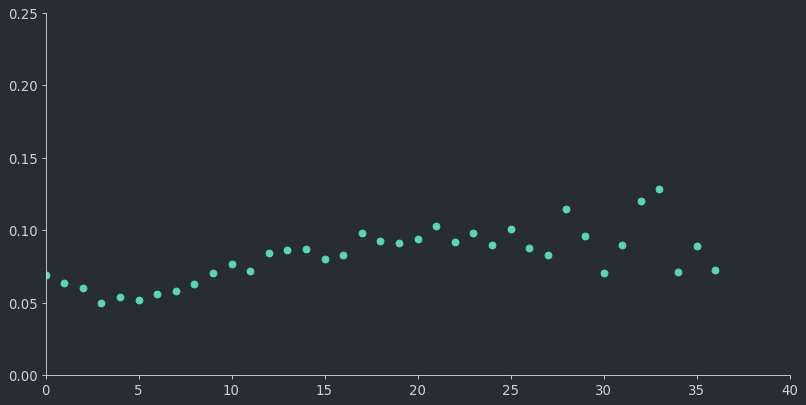

In [58]:
# Age of Car -- is correlated with default, but with the range of values so it may be better to take the log of this value
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,40)

# TO DO:  add axes titles and plot title

(0.0, 5.0)

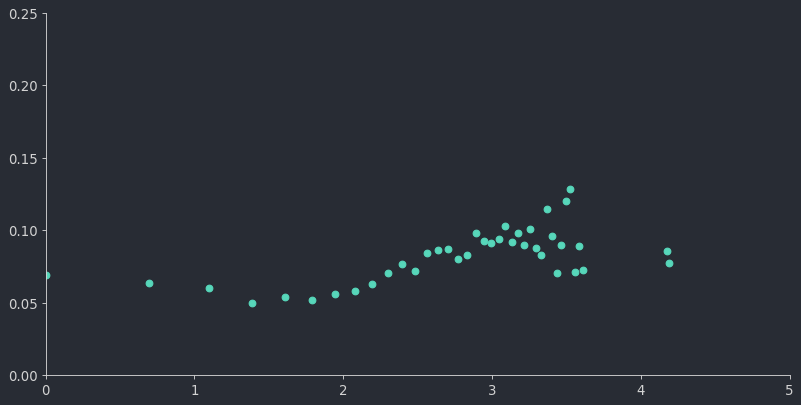

In [59]:
# Car age is correlated, so let's just take the log of it, adding 1 to avoid an -inf error

d['application_train_df']['own_car_age'] = np.log(d['application_train_df']['own_car_age'] + 1)
d['application_test_df']['own_car_age'] = np.log(d['application_test_df']['own_car_age'] + 1)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,5)

# TO DO:  add axes titles and plot title

Virtually all values with a NULL `own_car_age` has a "N" for `flag_own_car`, thus we do not need another binary variable reprenting that `own_car_age` is NULL. We fill the null `own_car_age` with the mean

In [60]:
d['application_train_df']['own_car_age'].mean()


2.246389474295695

In [61]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'target'].mean()


0.08500017247411656

In [62]:
d['application_train_df']['flag_own_car'].isna().sum()


0

In [63]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'flag_own_car'].value_counts()


flag_own_car
N    202924
Y         5
Name: count, dtype: int64

In [64]:
d['application_train_df']['own_car_age'].fillna(d['application_train_df']['own_car_age'].mean(),inplace=True)
d['application_test_df']['own_car_age'].fillna(d['application_test_df']['own_car_age'].mean(),inplace=True)


There does seem to be some correlation with hour of application, although this may be a fluke.
People who apply in the early-morning have the highest default rate, morning (pre-noon) ,followed by night and then day

In [65]:

def hour_of_application(hour):
    if hour > 17 or hour < 4:
        return 'night'
    elif hour < 9:
        return 'early-morning'
    elif hour <= 12:
        return 'morning'
    else:
        return 'afternoon'

In [66]:
d['application_train_df']['hour_appr_process_start'].apply(hour_of_application).value_counts()


hour_appr_process_start
morning          136568
afternoon        118765
early-morning     35828
night             16350
Name: count, dtype: int64

In [67]:
d['application_train_df']['hour_appr_process_start'] = d['application_train_df']['hour_appr_process_start'].apply(hour_of_application)
d['application_test_df']['hour_appr_process_start'] = d['application_test_df']['hour_appr_process_start'].apply(hour_of_application)


(0.0, 0.1)

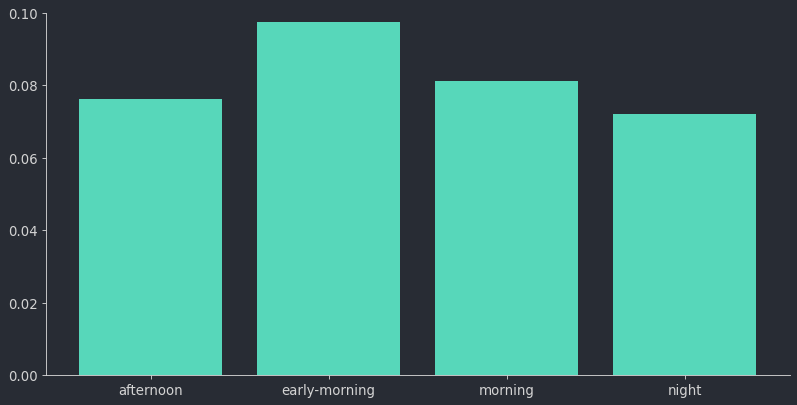

In [68]:
#There may be a correlation with when people start their application
col = 'hour_appr_process_start'
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].index, height = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].values)

ax.set_ylim(0,0.1)

# # TO DO:  add axes titles and plot title

In [69]:
# Values other than 'Working','Commercial associate','Pensioner','State servant' are extremely rare for the columns 'name_income_type' and will be grouped into an 'Other' category

print(d['application_train_df']['name_income_type'].value_counts())

d['application_train_df'].loc[~d['application_train_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'

name_income_type
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64


In [70]:
# majority of people are solo. Other then Family / spouse or partner, it's pretty sparse, so not worth one-hot encoding. Instead, we have a binary variable for "lives_alone"

print(d['application_train_df']['name_type_suite'].value_counts())

d['application_train_df']['lives_alone']  = np.where(d['application_train_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_train_df'].drop('name_type_suite',axis=1,inplace=True)

d['application_test_df']['lives_alone']  = np.where(d['application_test_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_test_df'].drop('name_type_suite',axis=1,inplace=True)

name_type_suite
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64


In [71]:
print(d['application_train_df']['name_education_type'].value_counts())

#grouping in Academic Degree with Higher Education as it is a form of Higher Education and there are only 164 rows with Academic Degree
d['application_train_df'].loc[d['application_train_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'
d['application_test_df'].loc[d['application_test_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'

name_education_type
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64


In [72]:
#unknown is 2 samples. saving a column by just making it Single / not married

print(d['application_train_df']['name_family_status'].value_counts())
d['application_train_df'].loc[d['application_train_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'
d['application_test_df'].loc[d['application_test_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'

name_family_status
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64


In [73]:
#Why are House / apartment not seperated? -- Makes this feature essentially useless. Will keep this as is and will one-hot encode it

d['application_train_df']['name_housing_type'].value_counts()

name_housing_type
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

In [74]:
d['application_train_df'].groupby('name_housing_type').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target').reset_index()


,name_housing_type,target,sk_id_curr
0,Office apartment,0.065724,2617
1,House / apartment,0.077957,272868
2,Co-op apartment,0.079323,1122
3,Municipal apartment,0.085397,11183
4,With parents,0.116981,14840
5,Rented apartment,0.123131,4881


In [75]:
d['application_test_df']['name_housing_type'].value_counts()


name_housing_type
House / apartment      43645
With parents            2234
Municipal apartment     1617
Rented apartment         718
Office apartment         407
Co-op apartment          123
Name: count, dtype: int64

In [76]:
d['application_train_df'][[x for x in d['application_train_df'].columns if 'amt_req_credit' in x]].isna().sum()


amt_req_credit_bureau_hour    41519
amt_req_credit_bureau_day     41519
amt_req_credit_bureau_week    41519
amt_req_credit_bureau_mon     41519
amt_req_credit_bureau_qrt     41519
amt_req_credit_bureau_year    41519
dtype: int64

For the `amt_req_credit` columns, these represent how many credit pulls they've had during certain time periods. The null values have a higher default rate, so we will fill the nulls with a mean and have a dummy variable for `unknown_credit`

In [77]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    print(col)
    print(d['application_train_df'][col].value_counts())

amt_req_credit_bureau_hour
amt_req_credit_bureau_hour
0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: count, dtype: int64
amt_req_credit_bureau_day
amt_req_credit_bureau_day
0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: count, dtype: int64
amt_req_credit_bureau_week
amt_req_credit_bureau_week
0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: count, dtype: int64
amt_req_credit_bureau_mon
amt_req_credit_bureau_mon
0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
23.0         1
27.0         1
22.0         1
Name: count, dtype: int64
am

In [78]:
d['application_train_df'].groupby('amt_req_credit_bureau_year')['target'].mean()


amt_req_credit_bureau_year
0.0     0.071350
1.0     0.073338
2.0     0.081049
3.0     0.079577
4.0     0.082553
5.0     0.083223
6.0     0.090713
7.0     0.092013
8.0     0.086037
9.0     0.108577
10.0    0.136364
11.0    0.064516
12.0    0.066667
13.0    0.052632
14.0    0.300000
15.0    0.000000
16.0    0.333333
17.0    0.000000
18.0    0.000000
19.0    0.000000
20.0    0.000000
21.0    0.000000
22.0    1.000000
23.0    0.000000
25.0    0.000000
Name: target, dtype: float64

In [79]:
d['application_train_df'].loc[d['application_train_df']['amt_req_credit_bureau_year'].isna(),'target'].mean()


0.10337435872732965

In [80]:
d['application_train_df']['amt_req_credit_bureau_year'].mean()


1.899974435321363

In [81]:
#dummy variable for the people with missing credit

d['application_train_df']['unknown_credit'] = np.where(d['application_train_df']['amt_req_credit_bureau_year'].isna(),1,0)
d['application_test_df']['unknown_credit'] = np.where(d['application_test_df']['amt_req_credit_bureau_year'].isna(),1,0)


In [82]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


To fill the nulls in `amt_annuity`, we will use the ratio of `amt_annuity` and `amt_credit` due to the high correlation. Could additionally be modeled, but not worth the time investment due to the small amount of rows

In [83]:
d['application_train_df']['amt_annuity'].isna().sum()

12

In [84]:
d['application_test_df']['amt_annuity'].isna().sum()

24

In [85]:
d['application_train_df'][['amt_annuity','amt_credit']].corr()


,amt_annuity,amt_credit
amt_annuity,1.000000,0.770138
amt_credit,0.770138,1.000000


In [86]:
annuity_to_credit_ratio = (d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_credit']).mean()


In [87]:
d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio


In [88]:
d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio


The instances where `amt_goods_price` is null are all revolving loans, making up 1% of the revolving loans. We will set them to the amt_credit in this case due to the correlation

In [89]:
d['application_train_df'].loc[d['application_train_df']['amt_goods_price'].isna(),'name_contract_type'].value_counts()


name_contract_type
Revolving loans    278
Name: count, dtype: int64

In [90]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] == 'Revolving loans',['amt_credit','amt_goods_price']].corr()


,amt_credit,amt_goods_price
amt_credit,1.000000,0.994901
amt_goods_price,0.994901,1.000000


In [91]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] != 'Revolving loans',['amt_credit','amt_goods_price']].corr()


,amt_credit,amt_goods_price
amt_credit,1.000000,0.986884
amt_goods_price,0.986884,1.000000


In [92]:
d['application_train_df']['amt_goods_price'].fillna(d['application_train_df']['amt_credit'],inplace=True)
d['application_test_df']['amt_goods_price'].fillna(d['application_test_df']['amt_credit'],inplace=True)


There is only one null value for this `days_last_phone_change`, so we will just fill it with the mean
It is interesting that 12% of the values have `0` as the value for this. This means that 12% of people applying for loans changed their number that day. While it may make sense to make these values null, there is a possibility that recently changing your phone number and applying for credit is correlated. A lot of people applying for emergency funding loans / personal credit loans may be going through something that requires them to also get a new phone number. Due to the possibility of this being rational, we will not void the values of `0`. These observations have higher probability to default, so we will create an additional dummy variable to catch any non-linearity of this relationship.

In [93]:
d['application_train_df']['days_last_phone_change'].isna().sum()


1

In [94]:
d['application_train_df']['days_last_phone_change'].value_counts()


days_last_phone_change
 0.0       37672
-1.0        2812
-2.0        2318
-3.0        1763
-4.0        1285
           ...  
-4051.0        1
-3593.0        1
-3622.0        1
-3570.0        1
-3538.0        1
Name: count, Length: 3773, dtype: int64

In [95]:
d['application_train_df']['days_last_phone_change'].fillna(d['application_train_df']['days_last_phone_change'].mean(),inplace=True)
d['application_test_df']['days_last_phone_change'].fillna(d['application_test_df']['days_last_phone_change'].mean(),inplace=True)

In [96]:
d['application_train_df'].loc[d['application_train_df']['days_last_phone_change'] == 0,'target'].mean()

0.0966500318538968

In [97]:
d['application_train_df'].loc[d['application_train_df']['days_last_phone_change'] != 0,'target'].mean()

0.0785060721393127

In [98]:
d['application_train_df']['changed_phone_day_of'] = np.where(d['application_train_df']['days_last_phone_change'] == 0,1,0)
d['application_test_df']['changed_phone_day_of'] = np.where(d['application_test_df']['days_last_phone_change'] == 0,1,0)

Only two null values in `cnt_fam_members`, but seemingly no correlation to default rate. Will fill with mean

In [99]:
d['application_train_df']['cnt_fam_members'].isna().sum()


2

In [100]:
d['application_train_df']['cnt_fam_members'].value_counts()


cnt_fam_members
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: count, dtype: int64

In [101]:
d['application_train_df']['cnt_fam_members'].fillna(d['application_train_df']['cnt_fam_members'].mean(),inplace=True)
d['application_test_df']['cnt_fam_members'].fillna(d['application_test_df']['cnt_fam_members'].mean(),inplace=True)


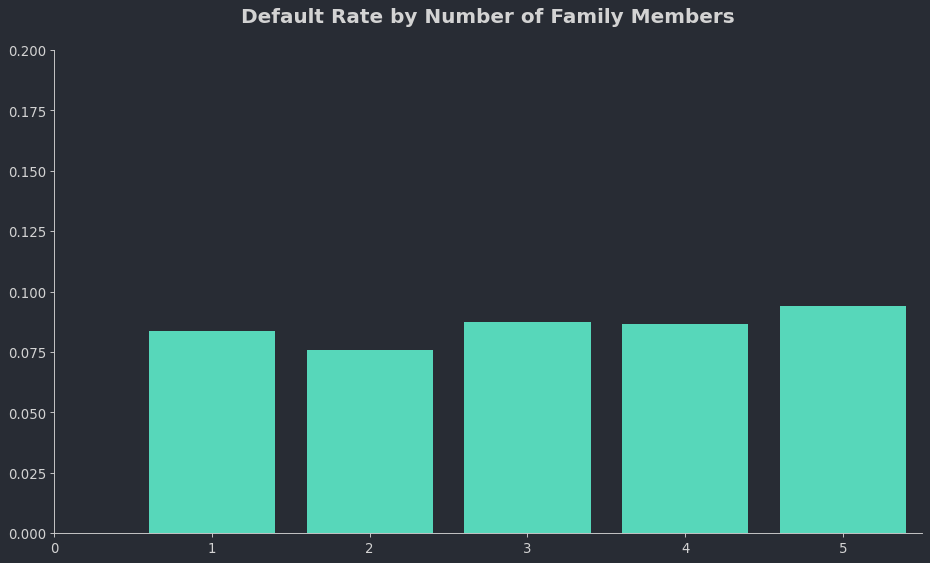

In [102]:
col = 'cnt_fam_members'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])


ax.set_xlim(0,5.5) #cut this off at 5 b/c there is very few samples of 6+
ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Number of Family Members')

plt.show()

# TO DO:  add axes titles

## External Sources (3 columns labeled with suffix _1, _2, and _3)


In [103]:
for i in range(1,4,1):
    pct_null = d['application_train_df'][f'ext_source_{i}'].isna().sum() / len(d['application_train_df'])
    print(f'Percent of null values in training dataset for ext_source_{i}: {pct_null:.3%}')

Percent of null values in training dataset for ext_source_1: 56.381%
Percent of null values in training dataset for ext_source_2: 0.215%
Percent of null values in training dataset for ext_source_3: 19.825%


In [104]:
for i in range(1,4,1):
    pct_null = d['application_test_df'][f'ext_source_{i}'].isna().sum() / len(d['application_train_df'])
    print(f'Percent of null values in the test dataset for ext_source_{i}: {pct_null:.3%}')

Percent of null values in the test dataset for ext_source_1: 6.677%
Percent of null values in the test dataset for ext_source_2: 0.003%
Percent of null values in the test dataset for ext_source_3: 2.819%


In [105]:
temp = d['application_train_df'][['target','ext_source_1','ext_source_2','ext_source_3']].copy()

In [106]:
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_2_bin'] = pd.qcut(temp['ext_source_2'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_3_bin'] = pd.qcut(temp['ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))

In [107]:
temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_2_bin').agg({'target':'mean'})
temp3 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/126193918.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/126193918.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp2 = temp.groupby('ext_source_2_bin').agg({'target':'mean'})
C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/126193918.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

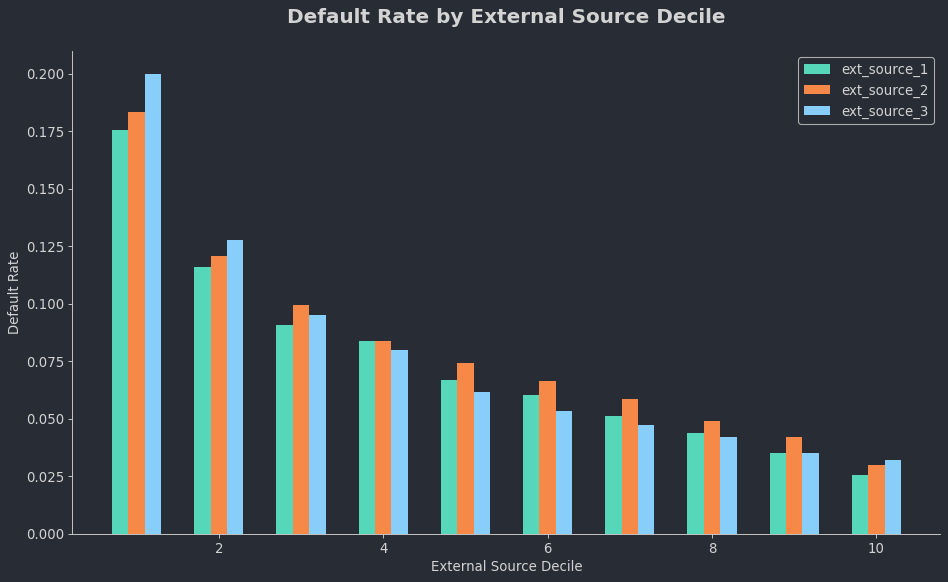

In [108]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_2')
ax.bar(x = np.arange(1,11,1) + 0.2, height = temp3['target'].values, width = 0.2, label = 'ext_source_3')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source Decile')

ax.legend()

plt.show()

In [109]:
temp.corr()


,target,ext_source_1,ext_source_2,ext_source_3,ext_source_1_bin,ext_source_2_bin,ext_source_3_bin
target,1.000000,-0.155317,-0.160472,-0.178919,-0.149048,-0.145196,-0.164200
ext_source_1,-0.155317,1.000000,0.213982,0.186846,0.990999,0.221784,0.182947
ext_source_2,-0.160472,0.213982,1.000000,0.109167,0.209146,0.953964,0.104700
ext_source_3,-0.178919,0.186846,0.109167,1.000000,0.180913,0.107462,0.979436
ext_source_1_bin,-0.149048,0.990999,0.209146,0.180913,1.000000,0.217259,0.177332
ext_source_2_bin,-0.145196,0.221784,0.953964,0.107462,0.217259,1.000000,0.104030
ext_source_3_bin,-0.164200,0.182947,0.104700,0.979436,0.177332,0.104030,1.000000


We can see above that the 3 External sources are very predictive in sloping default rates, and the correlation between the values is reasonable (~20%) with one another. It is worth attempting to model the nulls for `ext_source_1`, if possible.

In [110]:
ext_source_1_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_1']


In [111]:
ext_source_1_corr[ext_source_1_corr.abs() > 0.05]


target                        -0.155317
code_gender                    0.306729
flag_own_realty                0.080234
amt_credit                     0.168429
amt_annuity                    0.119402
amt_goods_price                0.175649
region_population_relative     0.099997
days_birth                    -0.600610
days_employed                  0.289848
days_registration             -0.181095
days_id_publish               -0.132375
own_car_age                   -0.064478
flag_emp_phone                -0.294147
flag_work_phone               -0.076540
flag_phone                     0.081241
cnt_fam_members               -0.096569
region_rating_client          -0.115341
region_rating_client_w_city   -0.115374
reg_city_not_live_city        -0.141000
reg_city_not_work_city        -0.185953
live_city_not_work_city       -0.119300
ext_source_1                   1.000000
ext_source_2                   0.213982
ext_source_3                   0.186846
days_last_phone_change        -0.132607


In [112]:
# remove all the other external source columns and the target column
features_to_model_ext_source_1 = [x for x in d['application_train_df'].isna().sum()[ext_source_1_corr[ext_source_1_corr.abs() > 0.05].index].index if x not in ['target','ext_source_1','ext_source_2','ext_source_3']]


In [113]:
d['application_train_df'].isna().sum()[features_to_model_ext_source_1]


code_gender                    0
flag_own_realty                0
amt_credit                     0
amt_annuity                    0
amt_goods_price                0
region_population_relative     0
days_birth                     0
days_employed                  0
days_registration              0
days_id_publish                0
own_car_age                    0
flag_emp_phone                 0
flag_work_phone                0
flag_phone                     0
cnt_fam_members                0
region_rating_client           0
region_rating_client_w_city    0
reg_city_not_live_city         0
reg_city_not_work_city         0
live_city_not_work_city        0
days_last_phone_change         0
flag_document_6                0
flag_document_8                0
housing_pca_1                  0
housing_pca_7                  0
housing_pca_10                 0
housing_pca_11                 0
housing_pca_12                 0
has_child                      0
has_multiple_children          0
unknown_cr

Due to the importance of `ext_source_1`, we model out the missing values using other dataset features and have a dummy variable that indicates if it was previously null and now modeled to capture the delta

In [114]:
#Build a Lasso regression to predict ext_source_1

X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),features_to_model_ext_source_1],d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),'ext_source_1'], test_size = 0.3, random_state = seed)

ridge_reg = Ridge(random_state=seed,alpha = 1).fit(X_train, y_train)


In [115]:
ridge_reg.score(X_test,y_test)


0.4554275675765629

In [116]:
d['application_train_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_1])
d['application_test_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_1])


In [117]:
d['application_train_df']['null_ext_source_1'] = np.where(d['application_train_df']['ext_source_1'].isna(),1,0)
d['application_test_df']['null_ext_source_1'] = np.where(d['application_test_df']['ext_source_1'].isna(),1,0)


C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/2677678380.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/2677678380.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp2 = temp.groupby('ext_source_1_modeled_bin').agg({'target':'mean'})


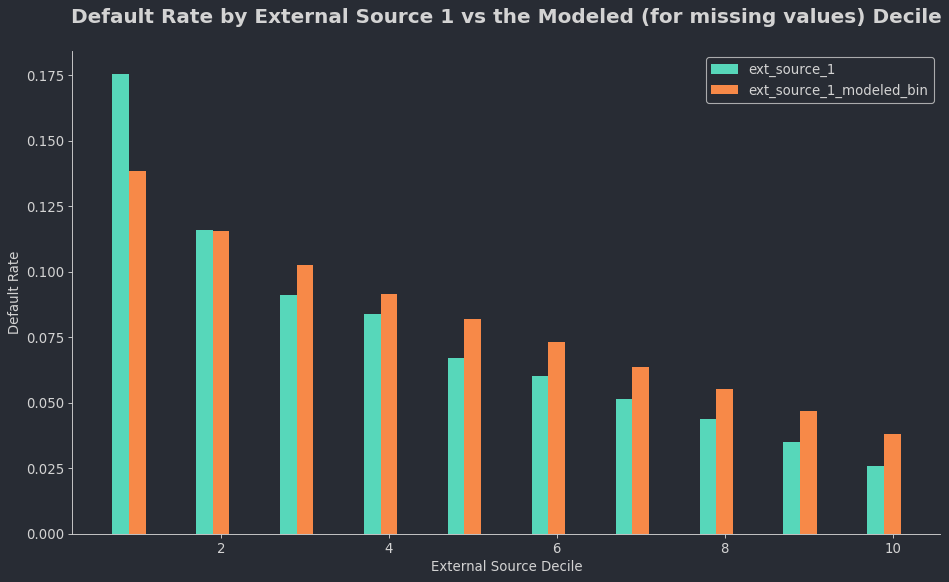

In [118]:
temp = d['application_train_df'][['target','ext_source_1','modeled_ext_source_1']].copy()
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_1_modeled_bin'] = pd.qcut(temp['modeled_ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))


temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_1_modeled_bin').agg({'target':'mean'})

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_1_modeled_bin')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source 1 vs the Modeled (for missing values) Decile')

ax.legend()

plt.show()

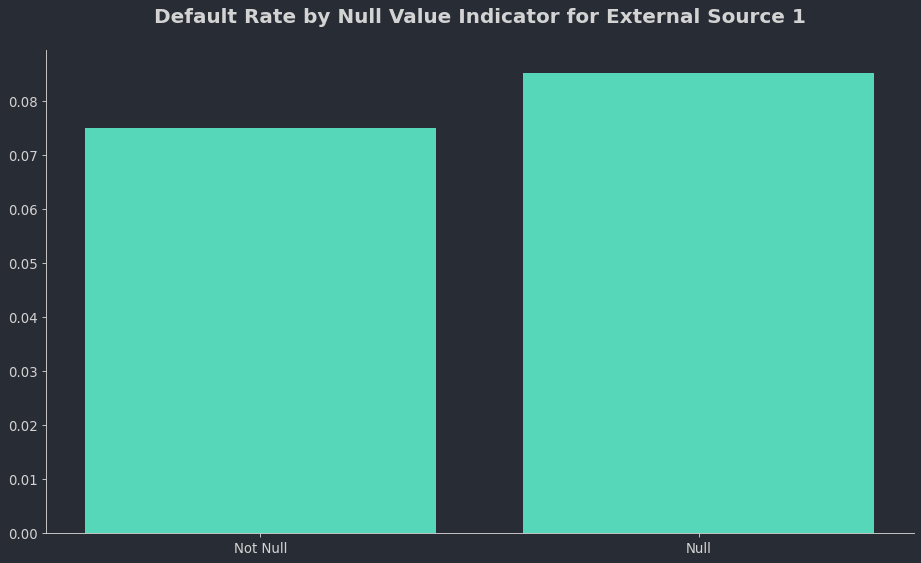

In [119]:
col = 'null_ext_source_1'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Null Value Indicator for External Source 1')

ax.set_xticks([0,1])
ax.set_xticklabels(['Not Null','Null'])

plt.show()

In [120]:
# Fill nulls with the modeled values. Drop Modeled values

d['application_train_df']['ext_source_1'].fillna(d['application_train_df']['modeled_ext_source_1'],inplace=True)
d['application_test_df']['ext_source_1'].fillna(d['application_test_df']['modeled_ext_source_1'],inplace=True)

d['application_train_df'].drop(columns = ['modeled_ext_source_1'],inplace=True)
d['application_test_df'].drop(columns = ['modeled_ext_source_1'],inplace=True)

We will repeat this process for `ext_source_2` as 20% of the training data is null. Only 3% of the test data is null for this column.

In [121]:
ext_source_2_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_2']

In [122]:
ext_source_2_corr[ext_source_2_corr.abs() > 0.05]

target                        -0.160472
amt_income_total               0.060925
amt_credit                     0.131228
amt_annuity                    0.125788
amt_goods_price                0.139330
region_population_relative     0.198924
days_birth                    -0.091996
days_registration             -0.059913
days_id_publish               -0.050955
own_car_age                   -0.060356
flag_phone                     0.061178
region_rating_client          -0.292895
region_rating_client_w_city   -0.288299
reg_city_not_work_city        -0.075970
live_city_not_work_city       -0.058900
ext_source_1                   0.179242
ext_source_2                   1.000000
ext_source_3                   0.109167
days_last_phone_change        -0.195764
flag_document_8                0.050684
housing_pca_1                  0.074238
housing_pca_7                 -0.073070
housing_pca_9                  0.051201
housing_pca_10                 0.111937
housing_pca_11                -0.114643


`ext_source_2` is also very predictive, but only 0.21% of the values are null, so we will drop these rows and fill in the missing values in the test dataset with the mean
<br> (only 0.003% of test values are null)

In [123]:

d['application_train_df'].dropna(subset = ['ext_source_2'],inplace=True)
d['application_test_df']['ext_source_2'].fillna(d['application_test_df']['ext_source_2'].mean(),inplace=True)


model to fill nulls for `external_source_3`

In [124]:
ext_source_3_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_3']

In [125]:
# remove all the other external source columns and the target column

features_to_model_ext_source_3 = [x for x in d['application_train_df'].isna().sum()[ext_source_3_corr[ext_source_3_corr.abs() > 0.05].index].index if x not in ['target','ext_source_1','ext_source_2','ext_source_3']]

In [126]:
# 77% overlap between the variables in the two models

len([x for x in features_to_model_ext_source_3 if x in features_to_model_ext_source_1]) / len(features_to_model_ext_source_3)

0.7692307692307693

In [127]:
#Build a Lasso regression to predict ext_source_1

X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'].loc[d['application_train_df']['ext_source_3'].notna(),
                                                                                  features_to_model_ext_source_3],
                                                                                  d['application_train_df'].loc[d['application_train_df']['ext_source_3'].notna(),'ext_source_3'],
                                                                                  test_size = 0.3, random_state = seed + 1) #seed + 1 to avoid the same split as the previous model for ext_source_1

ridge_reg = Ridge(random_state=seed,alpha = 1).fit(X_train, y_train)


In [128]:
ridge_reg.score(X_test,y_test)

0.06767815348491146

In [129]:
d['application_train_df']['modeled_ext_source_3'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_3])
d['application_test_df']['modeled_ext_source_3'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_3])


In [130]:
d['application_train_df']['null_ext_source_3'] = np.where(d['application_train_df']['ext_source_3'].isna(),1,0)
d['application_test_df']['null_ext_source_3'] = np.where(d['application_test_df']['ext_source_3'].isna(),1,0)


C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/656163308.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp1 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})
C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/656163308.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp2 = temp.groupby('ext_source_3_modeled_bin').agg({'target':'mean'})


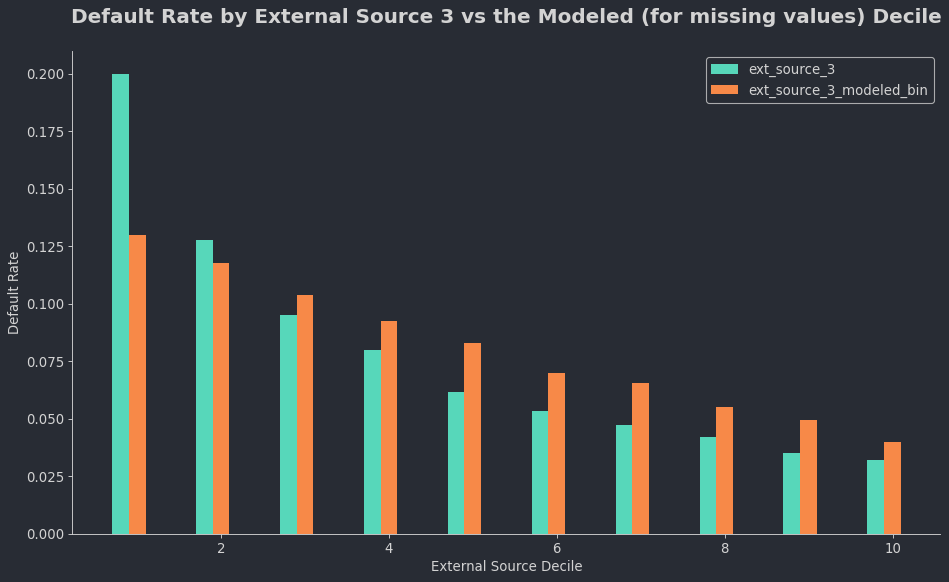

In [131]:
temp = d['application_train_df'][['target','ext_source_3','modeled_ext_source_3']].copy()
temp['ext_source_3_bin'] = pd.qcut(temp['ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_3_modeled_bin'] = pd.qcut(temp['modeled_ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))


temp1 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_3_modeled_bin').agg({'target':'mean'})

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)


ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_3')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_3_modeled_bin')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source 3 vs the Modeled (for missing values) Decile')

ax.legend()

plt.show()

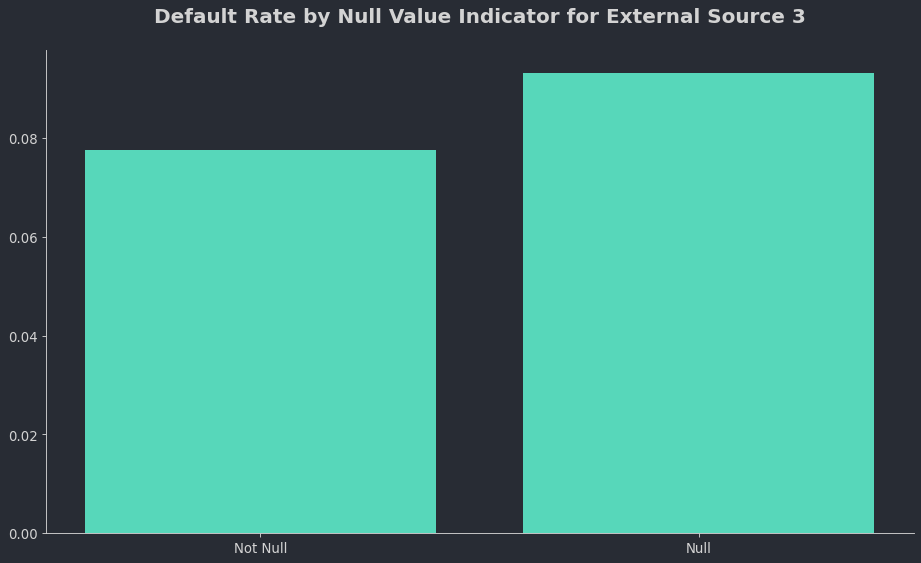

In [132]:

col = 'null_ext_source_3'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Null Value Indicator for External Source 3')

ax.set_xticks([0,1])
ax.set_xticklabels(['Not Null','Null'])

plt.show()

# TO DO:  add axes titles

In [133]:
# Fill nulls with the modeled values. Drop Modeled values

d['application_train_df']['ext_source_3'].fillna(d['application_train_df']['modeled_ext_source_3'],inplace=True)
d['application_test_df']['ext_source_3'].fillna(d['application_test_df']['modeled_ext_source_3'],inplace=True)

d['application_train_df'].drop(columns = ['modeled_ext_source_3'],inplace=True)
d['application_test_df'].drop(columns = ['modeled_ext_source_3'],inplace=True)

Not sure what the column `fondkapremont_mode` means, but the categorical variable seems to slope to default somewhat, especially with missing values having the highest default rate. The variable name and the column description is not informative.

In [134]:
d['application_train_df']['fondkapremont_mode'].value_counts()

fondkapremont_mode
reg oper account         73679
reg oper spec account    12059
not specified             5672
org spec account          5614
Name: count, dtype: int64

In [135]:

d['application_train_df']['fondkapremont_mode'].fillna('missing',inplace=True)
d['application_test_df']['fondkapremont_mode'].fillna('missing',inplace=True)


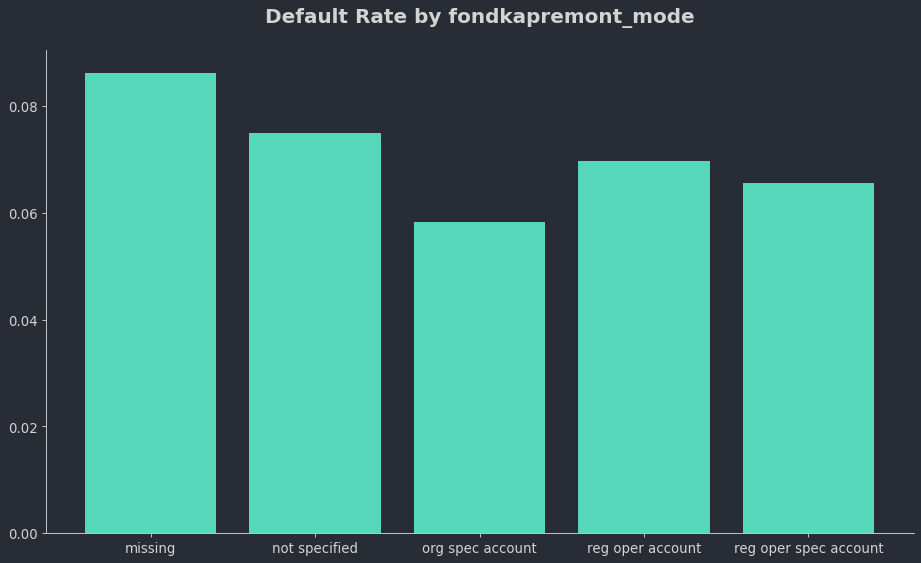

''

In [136]:
col = 'fondkapremont_mode'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by fondkapremont_mode')

plt.show()


ax.set_xlabel('Fondkapremont Mode')
ax.set_ylabel('Default Rate')

;

For `occupation_type`, nulls are theoretically have value because no known occupation hypothetically may be indicative of default risk. Off of a simple aggregation, it is not, but there may be hidden relationships with other variables

In [137]:
d['application_train_df']['occupation_type'].fillna('Unknown',inplace=True)
d['application_test_df']['occupation_type'].fillna('Unknown',inplace=True)


In [138]:
d['application_train_df']['occupation_type'].value_counts()


occupation_type
Unknown                  96143
Laborers                 55084
Sales staff              32015
Core staff               27519
Managers                 21346
Drivers                  18575
High skill tech staff    11361
Accountants               9788
Medicine staff            8513
Security staff            6709
Cooking staff             5932
Cleaning staff            4644
Private service staff     2649
Low-skill Laborers        2087
Waiters/barmen staff      1345
Secretaries               1304
Realty agents              749
HR staff                   563
IT staff                   525
Name: count, dtype: int64

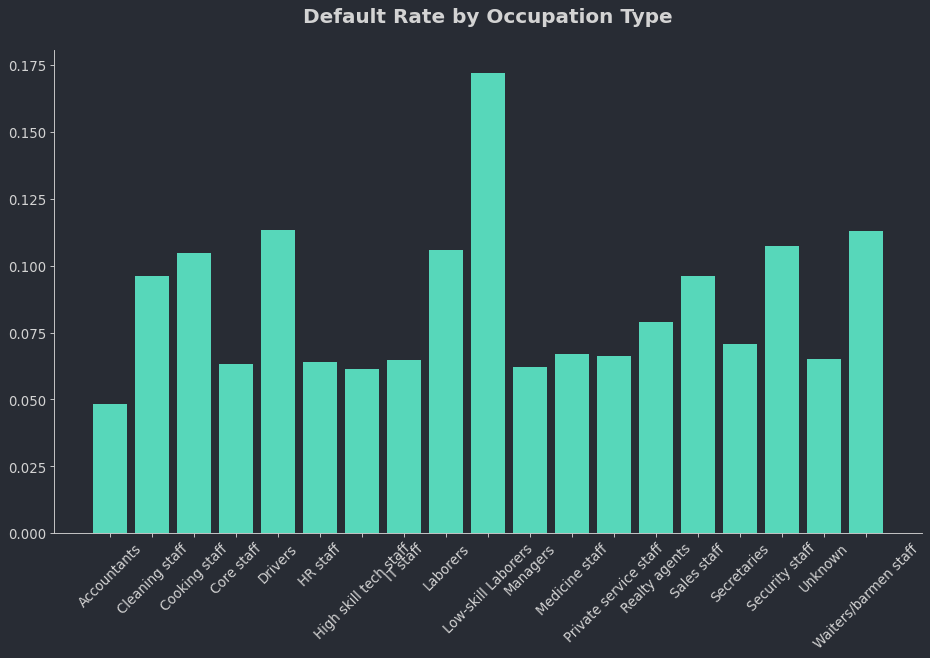

In [139]:
col = 'occupation_type'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Occupation Type')

plt.xticks(rotation = 45)

plt.show()

In [140]:
[x for x in d['application_train_df'].columns  if 'income' in x]

['amt_income_total', 'name_income_type']

In [141]:
#Need to find a secretary job or waiter job that pays an average of 160k/year myself
d['application_train_df'].groupby('occupation_type').agg({'amt_income_total':'mean','target':'mean'}).sort_values(by='target',ascending=False)

,amt_income_total,target
occupation_type,,
Low-skill Laborers,133235.844753,0.172017
Drivers,187020.722159,0.113271
Waiters/barmen staff,144293.266171,0.113011
Security staff,149700.324862,0.107468
Laborers,166392.771597,0.105711
Cooking staff,138475.073772,0.104686
Cleaning staff,130797.370155,0.096253
Sales staff,152337.532546,0.096142
Realty agents,194935.914553,0.078772


In [142]:
# to make this potentially more digestible by a model, let's do amt_income_total / avg of that occupation type to maybe segment higher performers in each job family

In [143]:
avg_income_by_occupation = d['application_train_df'].groupby('occupation_type').agg({'amt_income_total':'mean'}).to_dict()

In [144]:
d['application_train_df']['income_to_avg_occupation_income_ratio']  = d['application_train_df'].apply(lambda x: x['amt_income_total'] / avg_income_by_occupation['amt_income_total'][x['occupation_type']],axis=1)
d['application_test_df']['income_to_avg_occupation_income_ratio']  = d['application_test_df'].apply(lambda x: x['amt_income_total'] / avg_income_by_occupation['amt_income_total'][x['occupation_type']],axis=1)


In [145]:
#checking that we didnt introduce any inf or nan
inf_train = d['application_train_df'].loc[np.isinf(d['application_train_df']['income_to_avg_occupation_income_ratio'])]
nan_train = d['application_train_df'].loc[d['application_train_df']['income_to_avg_occupation_income_ratio'].isna()]
inf_test = d['application_test_df'].loc[np.isinf(d['application_test_df']['income_to_avg_occupation_income_ratio'])]
nan_test = d['application_test_df'].loc[d['application_test_df']['income_to_avg_occupation_income_ratio'].isna()]

print(len(inf_train),len(nan_train),len(inf_test),len(nan_test))

0 0 0 0


Let's do the same with organization type -- first aggregating all the similar orginizations. There is some differentiation, but often due to smaller sample sizes. There isn't the best sample size for the differentiated organization type for the model to reliably use

In [146]:
np.sort((d['application_train_df']['organization_type'].unique()))

array(['Advertising', 'Agriculture', 'Bank', 'Business Entity Type 1',
       'Business Entity Type 2', 'Business Entity Type 3', 'Cleaning',
       'Construction', 'Culture', 'Electricity', 'Emergency',
       'Government', 'Hotel', 'Housing', 'Industry: type 1',
       'Industry: type 10', 'Industry: type 11', 'Industry: type 12',
       'Industry: type 13', 'Industry: type 2', 'Industry: type 3',
       'Industry: type 4', 'Industry: type 5', 'Industry: type 6',
       'Industry: type 7', 'Industry: type 8', 'Industry: type 9',
       'Insurance', 'Kindergarten', 'Legal Services', 'Medicine',
       'Military', 'Mobile', 'Other', 'Police', 'Postal', 'Realtor',
       'Religion', 'Restaurant', 'School', 'Security',
       'Security Ministries', 'Self-employed', 'Services', 'Telecom',
       'Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4',
       'Trade: type 5', 'Trade: type 6', 'Trade: type 7',
       'Transport: type 1', 'Transport: type 2', 'Transport: type 3',


In [147]:
d['application_train_df'].loc[d['application_train_df']['organization_type'].str.contains('Industry:')].groupby('organization_type').agg({'target':'mean','sk_id_curr':'count','amt_income_total':'mean'}).sort_values(by='target',ascending=False)

,target,sk_id_curr,amt_income_total
organization_type,,,
Industry: type 13,0.134328,67,147915.671642
Industry: type 8,0.125000,24,172537.500000
Industry: type 1,0.110790,1038,173368.703757
Industry: type 3,0.106455,3269,148792.474809
Industry: type 4,0.101598,876,178097.835616
Industry: type 11,0.086635,2701,162669.618660
Industry: type 7,0.080460,1305,164892.579310
Industry: type 2,0.072052,458,171449.253275
Industry: type 6,0.071429,112,171212.946429


In [148]:
d['application_train_df'].loc[d['application_train_df']['organization_type'].str.contains('Trade:')].groupby('organization_type').agg({'target':'mean','sk_id_curr':'count','amt_income_total':'mean'}).sort_values(by='target',ascending=False)

,target,sk_id_curr,amt_income_total
organization_type,,,
Trade: type 3,0.103022,3475,160572.026201
Trade: type 7,0.094385,7819,167596.143369
Trade: type 1,0.086705,346,165790.073757
Trade: type 2,0.070222,1894,190803.130755
Trade: type 5,0.062500,48,182198.437500
Trade: type 6,0.046032,630,180047.314286
Trade: type 4,0.031250,64,191141.015625


In [149]:
d['application_train_df'].loc[d['application_train_df']['organization_type'].str.contains('Transport:')].groupby('organization_type').agg({'target':'mean','sk_id_curr':'count','amt_income_total':'mean'}).sort_values(by='target',ascending=False)

,target,sk_id_curr,amt_income_total
organization_type,,,
Transport: type 3,0.157806,1185,175412.278481
Transport: type 4,0.092747,5391,190744.482471
Transport: type 2,0.078075,2203,175407.040642
Transport: type 1,0.044776,201,189268.656716


In [150]:
d['application_train_df'].loc[d['application_train_df']['organization_type'].str.contains('Industry:'),'organization_type'] = 'Industry'
d['application_train_df'].loc[d['application_train_df']['organization_type'].str.contains('Trade:'),'organization_type'] = 'Trade'
d['application_train_df'].loc[d['application_train_df']['organization_type'].str.contains('Transport:'),'organization_type'] = 'Transport'
d['application_train_df'].loc[d['application_train_df']['organization_type'].str.contains('Business Entity'),'organization_type'] = 'Business Entity'

d['application_test_df'].loc[d['application_test_df']['organization_type'].str.contains('Industry:'),'organization_type'] = 'Industry'
d['application_test_df'].loc[d['application_test_df']['organization_type'].str.contains('Trade:'),'organization_type'] = 'Trade'
d['application_test_df'].loc[d['application_test_df']['organization_type'].str.contains('Transport:'),'organization_type'] = 'Transport'
d['application_test_df'].loc[d['application_test_df']['organization_type'].str.contains('Business Entity'),'organization_type'] = 'Business Entity'


In [151]:
np.sort((d['application_train_df']['organization_type'].unique()))

array(['Advertising', 'Agriculture', 'Bank', 'Business Entity',
       'Cleaning', 'Construction', 'Culture', 'Electricity', 'Emergency',
       'Government', 'Hotel', 'Housing', 'Industry', 'Insurance',
       'Kindergarten', 'Legal Services', 'Medicine', 'Military', 'Mobile',
       'Other', 'Police', 'Postal', 'Realtor', 'Religion', 'Restaurant',
       'School', 'Security', 'Security Ministries', 'Self-employed',
       'Services', 'Telecom', 'Trade', 'Transport', 'University', 'XNA'],
      dtype=object)

In [152]:
#get avg income total by organization type and get income ratio with that
avg_income_by_organization_type = d['application_train_df'].groupby('organization_type').agg({'amt_income_total':'mean'}).to_dict()

d['application_train_df']['income_to_avg_organization_income_ratio']  = d['application_train_df'].apply(lambda x: x['amt_income_total'] / avg_income_by_organization_type['amt_income_total'][x['organization_type']],axis=1)
d['application_test_df']['income_to_avg_organization_income_ratio']  = d['application_test_df'].apply(lambda x: x['amt_income_total'] / avg_income_by_organization_type['amt_income_total'][x['organization_type']],axis=1)

In [153]:
#checking that we didnt introduce any inf or nan
inf_train = d['application_train_df'].loc[np.isinf(d['application_train_df']['income_to_avg_organization_income_ratio'])]
nan_train = d['application_train_df'].loc[d['application_train_df']['income_to_avg_organization_income_ratio'].isna()]
inf_test = d['application_test_df'].loc[np.isinf(d['application_test_df']['income_to_avg_organization_income_ratio'])]
nan_test = d['application_test_df'].loc[d['application_test_df']['income_to_avg_organization_income_ratio'].isna()]

print(len(inf_train),len(nan_train),len(inf_test),len(nan_test))

0 0 0 0


Many of the columns `flag_document_n` seem to be correlated with risk, but many are sparse. Instead, we will create another column that sums them all

In [154]:
flag_doc_cols = [x for x in d['application_train_df'].columns if 'flag_document' in x]

In [155]:
d['application_train_df'].groupby(flag_doc_cols[0]).agg({'target':'mean','sk_id_curr':'count'})

,target,sk_id_curr
flag_document_2,,
0,0.080723,306838
1,0.307692,13


In [156]:
d['application_train_df'].groupby(flag_doc_cols[1]).agg({'target':'mean','sk_id_curr':'count'})

,target,sk_id_curr
flag_document_3,,
0,0.061800,88980
1,0.088465,217871


In [157]:
d['application_train_df'].groupby(flag_doc_cols[2]).agg({'target':'mean','sk_id_curr':'count'})

,target,sk_id_curr
flag_document_4,,
0,0.08074,306826
1,0.00000,25


In [158]:
d['application_train_df'][flag_doc_cols].sum()

flag_document_2         13
flag_document_3     217871
flag_document_4         25
flag_document_5       4636
flag_document_6      26994
flag_document_7         58
flag_document_8      24993
flag_document_9       1197
flag_document_10         7
flag_document_11      1198
flag_document_12         2
flag_document_13      1084
flag_document_14       903
flag_document_15       372
flag_document_16      3051
flag_document_17        82
flag_document_18      2497
flag_document_19       183
flag_document_20       156
flag_document_21       103
dtype: int64

In [159]:
d['application_train_df']['flag_document_sum'] = d['application_train_df'][flag_doc_cols].sum(axis=1)
d['application_test_df']['flag_document_sum'] = d['application_test_df'][flag_doc_cols].sum(axis=1)

Doing the same thing with region columns, denoted `reg_n`

In [160]:
reg_cols = [x for x in d['application_train_df'].columns if 'reg_' in x]

In [161]:
d['application_train_df'][reg_cols].sum()

reg_region_not_live_region     4645
reg_region_not_work_region    15570
reg_city_not_live_city        23989
reg_city_not_work_city        70709
dtype: int64

In [162]:
d['application_train_df'].groupby(reg_cols[0]).agg({'target':'mean','sk_id_curr':'count'})

,target,sk_id_curr
reg_region_not_live_region,,
0,0.080544,302206
1,0.093003,4645


In [163]:
d['application_train_df'].groupby(reg_cols[1]).agg({'target':'mean','sk_id_curr':'count'})

,target,sk_id_curr
reg_region_not_work_region,,
0,0.080290,291281
1,0.089017,15570


In [164]:
d['application_train_df'].groupby(reg_cols[2]).agg({'target':'mean','sk_id_curr':'count'})

,target,sk_id_curr
reg_city_not_live_city,,
0,0.077207,282862
1,0.122306,23989


In [165]:
d['application_train_df'].groupby(reg_cols[3]).agg({'target':'mean','sk_id_curr':'count'})

,target,sk_id_curr
reg_city_not_work_city,,
0,0.073109,236142
1,0.106196,70709


In [166]:
d['application_train_df']['reg_flag_sum'] = d['application_train_df'][reg_cols].sum(axis=1)
d['application_test_df']['reg_flag_sum'] = d['application_test_df'][reg_cols].sum(axis=1)

There are only a small amount of `null` values for social circle variables (~0.27%), so we will just drop these in the training dataset, and fill the test dataset with the mean.

In [167]:
d['application_train_df'].isna().sum()[[x for x in d['application_train_df'].columns if 'social_circle' in x]]


obs_30_cnt_social_circle    1017
def_30_cnt_social_circle    1017
obs_60_cnt_social_circle    1017
def_60_cnt_social_circle    1017
dtype: int64

In [168]:
d['application_test_df'].isna().sum()[[x for x in d['application_train_df'].columns if 'social_circle' in x]]


obs_30_cnt_social_circle    29
def_30_cnt_social_circle    29
obs_60_cnt_social_circle    29
def_60_cnt_social_circle    29
dtype: int64

In [169]:
d['application_train_df'].dropna(subset = ['obs_30_cnt_social_circle','def_30_cnt_social_circle','obs_60_cnt_social_circle','def_60_cnt_social_circle'],inplace=True)


In [170]:
for col in ['obs_30_cnt_social_circle','def_30_cnt_social_circle','obs_60_cnt_social_circle','def_60_cnt_social_circle']:
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


In [171]:
d['application_train_df']['obs_60_cnt_social_circle'].value_counts()


obs_60_cnt_social_circle
0.0      164274
1.0       48776
2.0       29713
3.0       20174
4.0       13917
5.0        9450
6.0        6341
7.0        4337
8.0        2881
9.0        1953
10.0       1333
11.0        834
12.0        618
13.0        400
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0         13
24.0         12
25.0         11
27.0          5
29.0          2
28.0          1
47.0          1
344.0         1
30.0          1
26.0          1
Name: count, dtype: int64

In [172]:
d['application_train_df']['def_60_cnt_social_circle'].value_counts()


def_60_cnt_social_circle
0.0     280110
1.0      21802
2.0       3165
3.0        597
4.0        135
5.0         20
6.0          3
7.0          1
24.0         1
Name: count, dtype: int64

In [173]:
# We should also try taking the log of each due to the distribution
for col in [x for x in d['application_train_df'].columns if 'social_circle' in x]:
    d['application_train_df'][col + '_log'] = np.log(d['application_train_df'][col] + 1)
    d['application_test_df'][col + '_log'] = np.log(d['application_test_df'][col] + 1)


In [174]:
d['application_train_df']


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,fondkapremont_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,housing_pca_1,housing_pca_2,housing_pca_3,housing_pca_4,housing_pca_5,housing_pca_6,housing_pca_7,housing_pca_8,housing_pca_9,housing_pca_10,housing_pca_11,housing_pca_12,has_child,has_multiple_children,lives_alone,unknown_credit,changed_phone_day_of,null_ext_source_1,null_ext_source_3,income_to_avg_occupation_income_ratio,income_to_avg_organization_income_ratio,flag_document_sum,reg_flag_sum,obs_30_cnt_social_circle_log,def_30_cnt_social_circle_log,obs_60_cnt_social_circle_log,def_60_cnt_social_circle_log
0,100002,1,Cash loans,0,N,1,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,2.246389,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,morning,0,0,0,0,0,0,Business Entity,0.083037,0.262949,0.139376,reg oper account,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,0.483611,-0.894462,-0.603860,-1.507294,-0.391251,-0.180978,0.031292,-0.547214,0.655574,0.231221,0.045989,-0.214656,0,0,1,0,0,0,0,1.217000,1.080357,1,0,1.098612,1.098612,1.098612,1.098612
1,100003,0,Cash loans,1,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,2.246389,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,morning,0,0,0,0,0,0,School,0.311267,0.622246,0.497382,reg oper account,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.936382,-1.418267,-0.664634,-1.332093,-0.229277,-0.185672,0.030116,-0.228809,-0.171834,-0.236433,0.937733,-0.321162,0,0,0,0,0,0,1,1.563510,1.739271,1,0,0.693147,0.000000,0.693147,0.000000
2,100004,0,Revolving loans,0,Y,1,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,3.295837,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,morning,0,0,0,0,0,0,Government,0.512250,0.555912,0.729567,missing,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.996308,-1.110654,-0.687475,-1.414920,-0.242330,-0.194248,-0.011471,-0.234908,-0.194370,-0.288674,0.913786,-0.359487,0,0,1,0,0,1,0,0.405667,0.419606,0,0,0.000000,0.000000,0.000000,0.000000
3,100006,0,Cash loans,1,N,1,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,2.246389,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,afternoon,0,0,0,0,0,0,Business Entity,0.655903,0.650442,0.544911,missing,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### More Novel Features

In [175]:
#I accidentally overwrote my dataframe but wanted to include these before I hopped of. i.e. no graphs or analysis, just code. Will delete this comment later
d['application_train_df']['payment_to_income_ratio'] = d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_income_total']
d['application_train_df']['additional_credit_pct_over_price'] = (d['application_train_df']['amt_credit'] - d['application_train_df']['amt_goods_price']) / d['application_train_df']['amt_goods_price']

d['application_test_df']['payment_to_income_ratio'] = d['application_test_df']['amt_annuity'] / d['application_test_df']['amt_income_total']
d['application_test_df']['additional_credit_pct_over_price'] = (d['application_test_df']['amt_credit'] - d['application_test_df']['amt_goods_price']) / d['application_test_df']['amt_goods_price']

Higher credit payment (`amt_annuity`) relative to income is correlated with higher default rates

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/758665480.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})


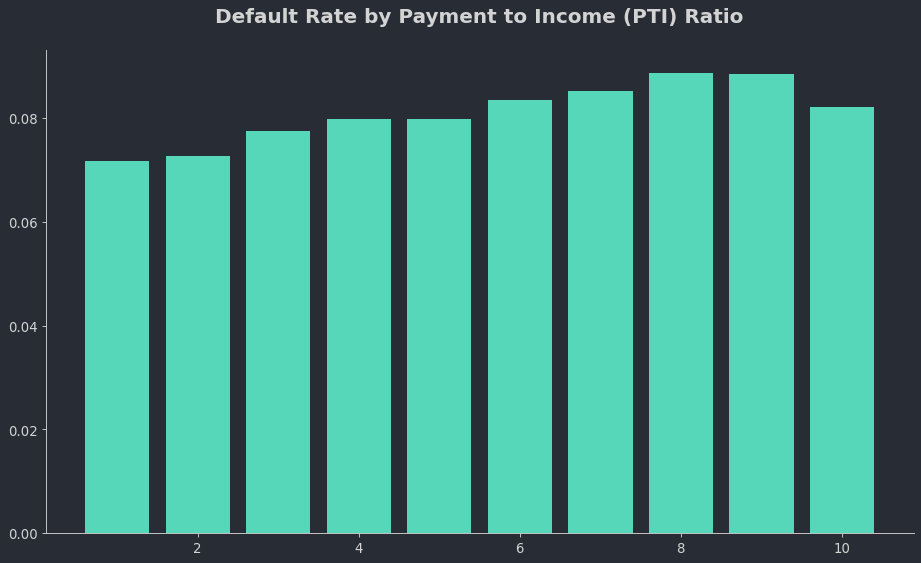

In [176]:
col = 'payment_to_income_ratio'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Payment to Income (PTI) Ratio')

plt.show()

# TO DO:  add axes titles

People who get credit for more than the item they are buying that was that catalyst to applying for credit in the first place default more often

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/2903599488.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})


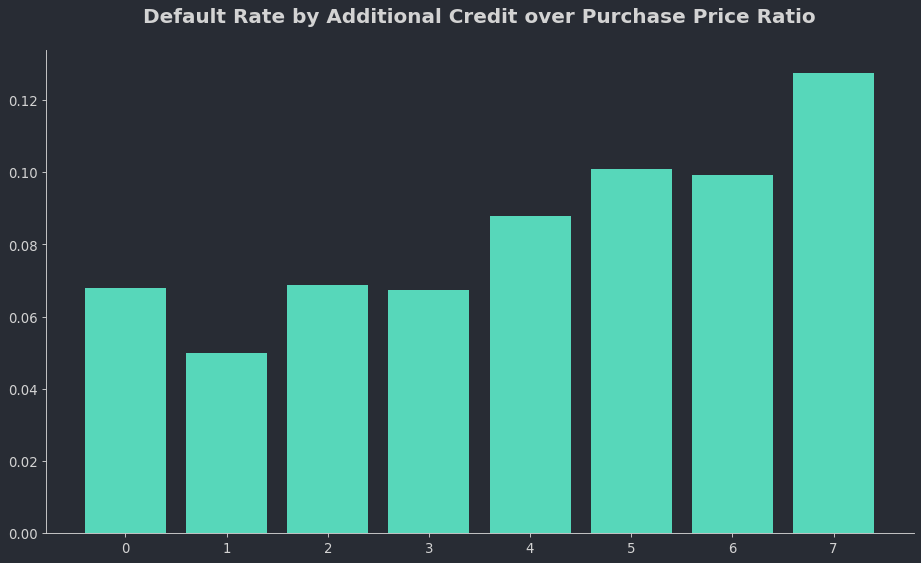

In [177]:
col = 'additional_credit_pct_over_price'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp[bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Additional Credit over Purchase Price Ratio')

plt.show()

# TO DO:  add axes titles

In [178]:
#making age into years instead of negative days
d['application_train_df']['age_years'] = (d['application_train_df']['days_birth'].abs() / 365).astype(int)
d['application_test_df']['age_years'] = (d['application_test_df']['days_birth'].abs() / 365).astype(int)

In [179]:
d['application_train_df']['down_payment'] = d['application_train_df']['amt_goods_price'] - d['application_train_df']['amt_credit']
d['application_test_df']['down_payment'] = d['application_test_df']['amt_goods_price'] - d['application_test_df']['amt_credit']

d['application_train_df']['down_payment_pct'] = d['application_train_df']['down_payment'] / d['application_train_df']['amt_goods_price']
d['application_test_df']['down_payment_pct'] = d['application_test_df']['down_payment'] / d['application_test_df']['amt_goods_price']

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/3072383566.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})


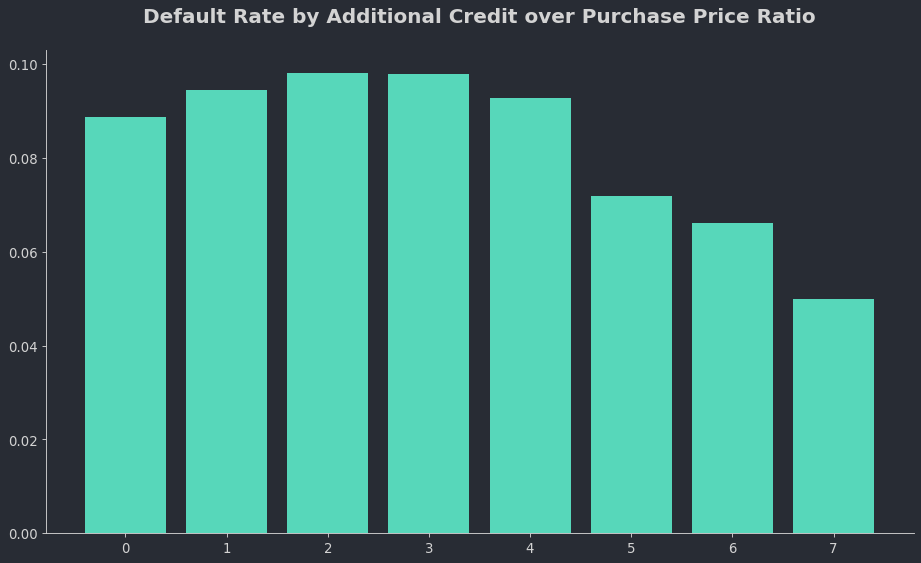

In [180]:
col = 'down_payment'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp[bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Additional Credit over Purchase Price Ratio')

plt.show()

# TO DO:  add axes titles

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/1707125551.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})


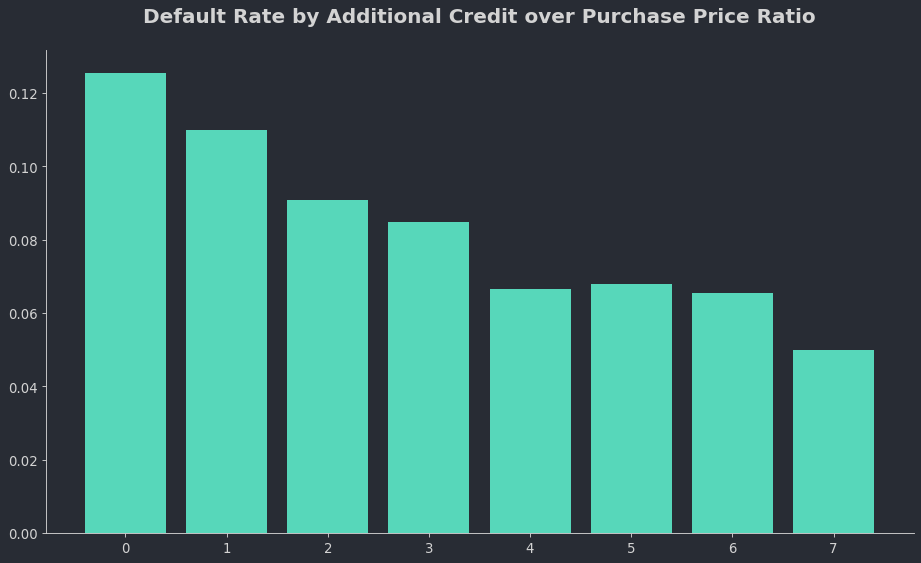

In [181]:
col = 'down_payment_pct'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp[bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Additional Credit over Purchase Price Ratio')

plt.show()

# TO DO:  add axes titles

### One hot encoding object features and turning some features into object features

With the population feature, we can segment out different regions to potentially segment out some areas that default at a higher rate

In [182]:
d['application_train_df']['region_population_relative'].value_counts() 

region_population_relative
0.035792    16318
0.046220    13333
0.030755    12111
0.025164    11902
0.026392    11507
0.031329    11272
0.028663    11065
0.019101     8638
0.072508     8294
0.020713     8027
0.018850     7611
0.020246     7138
0.018634     7013
0.022625     6898
0.015221     6804
0.032561     6576
0.024610     6372
0.018029     6148
0.019689     6121
0.018801     6074
0.018209     6027
0.014520     4740
0.016612     4381
0.007020     4091
0.022800     3795
0.010032     3553
0.010006     3550
0.014464     3409
0.004960     3284
0.011703     3233
0.010966     3088
0.011657     3065
0.010147     3061
0.010643     2984
0.007330     2964
0.007120     2856
0.006629     2799
0.009175     2769
0.010500     2672
0.010276     2584
0.009657     2455
0.006852     2427
0.008625     2285
0.009630     2248
0.010556     2175
0.009334     2077
0.007305     2011
0.006207     1932
0.009549     1829
0.008019     1811
0.008230     1802
0.006008     1791
0.003069     1771
0.008575     1756
0

In [183]:
d['application_test_df']['region_population_relative'].value_counts()

region_population_relative
0.035792    2582
0.046220    2497
0.030755    1991
0.026392    1805
0.028663    1740
0.025164    1599
0.031329    1595
0.072508    1565
0.019101    1466
0.020713    1327
0.018850    1288
0.020246    1146
0.018634    1116
0.032561    1088
0.015221    1085
0.018209    1083
0.022625    1060
0.018801     951
0.018029     897
0.024610     860
0.014520     846
0.019689     805
0.010032     676
0.010006     674
0.007020     659
0.016612     652
0.022800     601
0.004960     583
0.014464     552
0.011703     523
0.011657     522
0.010147     515
0.010643     511
0.007120     490
0.006629     451
0.007330     411
0.010276     397
0.010500     395
0.009175     374
0.009334     371
0.006008     371
0.010966     360
0.008625     357
0.009657     355
0.009549     341
0.003069     336
0.010556     324
0.007305     316
0.009630     316
0.008474     299
0.006207     284
0.008230     275
0.006305     269
0.008575     269
0.007114     269
0.008019     268
0.005084     267
0.00

In [184]:
#Any less than 2k (arbitrary) will be grouped into 'Other'
region_map = {}
regions_to_map = d['application_train_df']['region_population_relative'].value_counts()[d['application_train_df']['region_population_relative'].value_counts() >= 2000].index
for i,region in enumerate(regions_to_map):
    region_map[region] = i
print(f'{len(region_map)} out of {len(d["application_train_df"]["region_population_relative"].unique())} regions mapped. The rest will be mapped to other')
# other_index = d['application_train_df']['region_population_relative'].value_counts()[d['application_train_df']['region_population_relative'].value_counts() > 2000].index

47 out of 81 regions mapped. The rest will be mapped to other


In [185]:
d['application_train_df']['region'] = d['application_train_df']['region_population_relative'].map(region_map)
d['application_train_df']['region'] = d['application_train_df']['region'].astype(str)
d['application_train_df'].loc[~d['application_train_df']['region_population_relative'].isin(regions_to_map),'region'] = 'Other'

d['application_test_df']['region'] = d['application_test_df']['region_population_relative'].map(region_map)
d['application_test_df']['region'] = d['application_test_df']['region'].astype(str)
d['application_test_df'].loc[~d['application_test_df']['region_population_relative'].isin(regions_to_map),'region'] = 'Other'

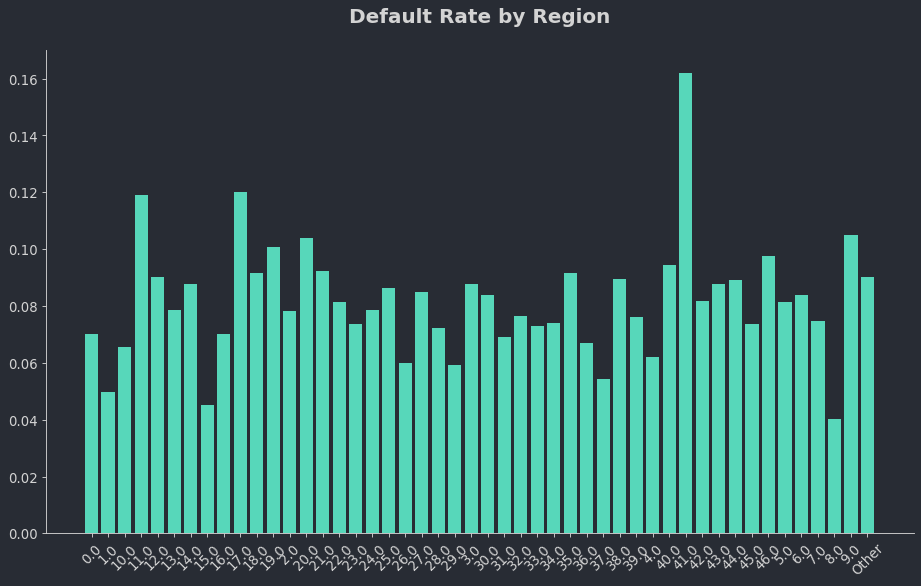

In [186]:
col = 'region'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Region')

plt.xticks(rotation = 45)

plt.show()

although `region_rating_client` seems semi-linear, it makes more sense for it to be categorical

In [187]:
d['application_train_df']['region_rating_client'].value_counts()

region_rating_client
2    225788
3     48151
1     31895
Name: count, dtype: int64

In [188]:
#although this seems linear, it makes more sense for it to be categorical
d['application_train_df'].groupby('region_rating_client').agg({'target':'mean','sk_id_curr':'count'})

d['application_train_df']['region_rating_client'] = d['application_train_df']['region_rating_client'].astype(str)
d['application_test_df']['region_rating_client'] = d['application_test_df']['region_rating_client'].astype(str)

In [189]:
object_cols = []

for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == 'object':
        object_cols.append(col)


In [190]:
# one-hot encode all the object columns

for col in object_cols:
    d['application_train_df'] = pd.get_dummies(d['application_train_df'],columns = [col],prefix=col)
    d['application_test_df'] = pd.get_dummies(d['application_test_df'],columns = [col],prefix=col)

In [191]:
# convert all the new boolean columns to int

for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == bool:
        d['application_train_df'][col] = d['application_train_df'][col].astype(int)
        d['application_test_df'][col] = d['application_test_df'][col].astype(int)

In [192]:
train_cols = d['application_train_df'].columns
test_col = d['application_test_df'].columns

In [193]:
#Testing that train and test have all the same columns (except for target)
[x for x in train_cols if x not in test_col]

['target']

In [194]:
[x for x in test_col if x not in train_cols]

[]

## Credit Card Data

Credit card utilization rate is a very strong predictor of subsequent loans. This data is available for about ~30% of the population of the training data

In [195]:
#grouping by each person "sk_id_curr"

cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'amt_balance':'sum','amt_credit_limit_actual':'sum'})

In [196]:
cc_grp['avg_credit_utilization_rate'] = cc_grp['amt_balance'] / cc_grp['amt_credit_limit_actual']


In [197]:
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')


In [198]:
# eliminate any infinite values
cc_grp = cc_grp[~np.isinf(cc_grp['avg_credit_utilization_rate'])].copy()

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/1413188222.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})


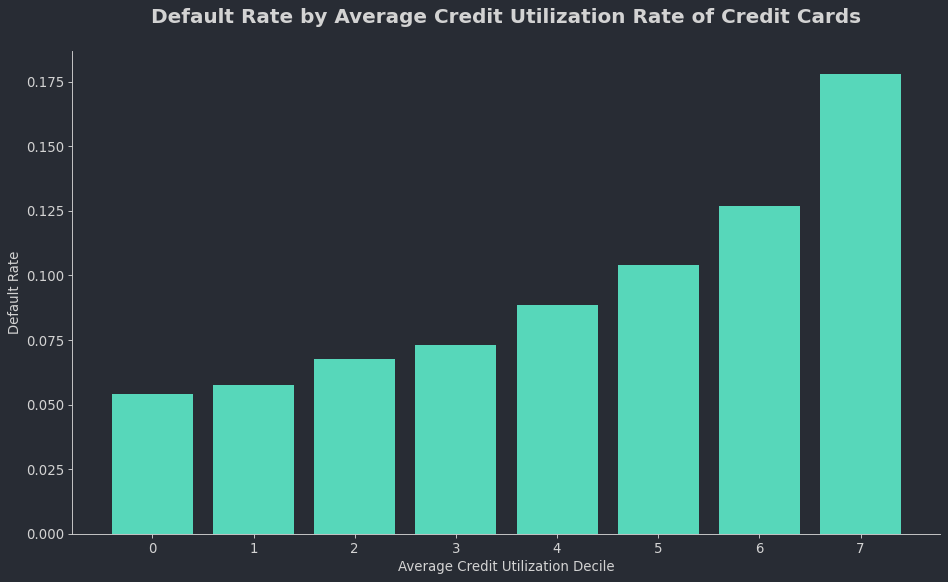

In [199]:
col = 'avg_credit_utilization_rate'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Average Credit Utilization Rate of Credit Cards')
ax.set_xlabel('Average Credit Utilization Decile')
ax.set_ylabel('Default Rate')

plt.show()


In [200]:
#merge findings into train and test datasets
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','avg_credit_utilization_rate']],how='left',on='sk_id_curr')
d['application_train_df']['no_previous_credit_card_history_ind'] = np.where(d['application_train_df']['avg_credit_utilization_rate'].isna(),1,0)
d['application_train_df']['avg_credit_utilization_rate'].fillna(d['application_train_df']['avg_credit_utilization_rate'].mean(),inplace=True)

In [201]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','avg_credit_utilization_rate']],how='left',on='sk_id_curr')
d['application_test_df']['no_previous_credit_card_history_ind'] = np.where(d['application_test_df']['avg_credit_utilization_rate'].isna(),1,0)
d['application_test_df']['avg_credit_utilization_rate'].fillna(d['application_test_df']['avg_credit_utilization_rate'].mean(),inplace=True)

ATM Withdrawl rate is correlated with default rate

In [202]:
d['credit_card_balance_df']['atm_withdrawal'] = np.where(d['credit_card_balance_df']['amt_drawings_atm_current'] > 0,1,0)
cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'atm_withdrawal':'sum','cnt_drawings_atm_current':'sum','months_balance':'count'})
cc_grp['pct_atm'] = cc_grp['atm_withdrawal'] / cc_grp['months_balance']
cc_grp['atm_per_month'] = cc_grp['cnt_drawings_atm_current'] / cc_grp['months_balance']
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')


C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/1406608500.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})


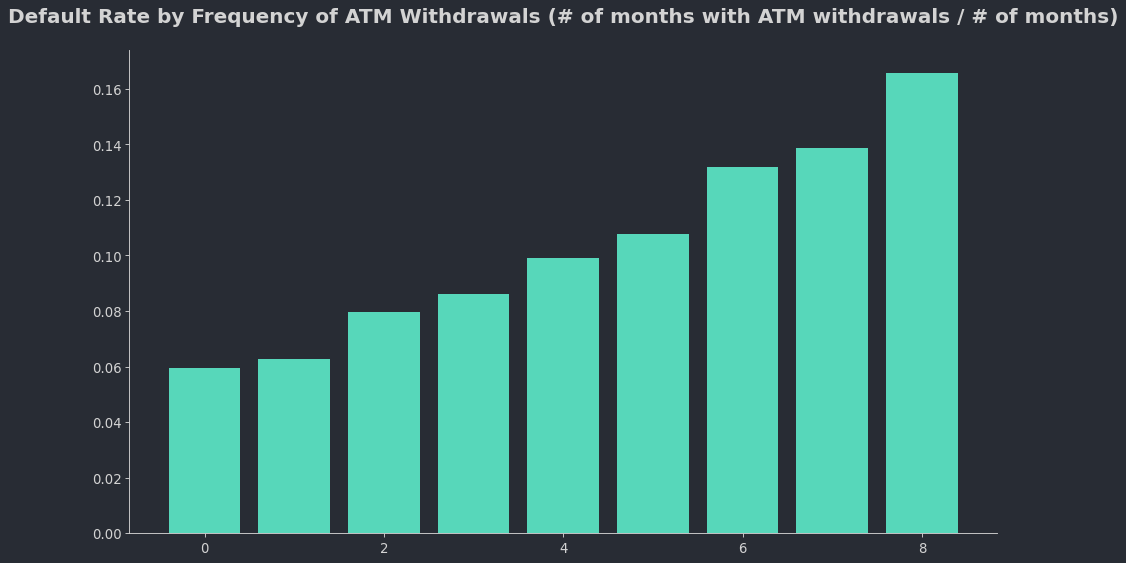

''

In [203]:
col = 'pct_atm'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 15, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Frequency of ATM Withdrawals (# of months with ATM withdrawals / # of months)')

plt.show()

# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('ATM Withdrawal Frequency Decile')

;

In [204]:
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','atm_per_month']],how='left',on='sk_id_curr')


In [205]:
#No need for an additional dummy variable for no CC history
d['application_train_df'].loc[d['application_train_df']['atm_per_month'].isna(),'no_previous_credit_card_history_ind'].value_counts()

no_previous_credit_card_history_ind
1    218986
Name: count, dtype: int64

In [206]:
d['application_train_df']['atm_per_month'].fillna(d['application_train_df']['atm_per_month'].mean(),inplace=True)

In [207]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','atm_per_month']],how='left',on='sk_id_curr')

In [208]:
d['application_test_df'].loc[d['application_test_df']['atm_per_month'].isna(),'no_previous_credit_card_history_ind'].value_counts()

no_previous_credit_card_history_ind
1    32091
Name: count, dtype: int64

In [209]:
d['application_test_df']['atm_per_month'].fillna(d['application_test_df']['atm_per_month'].mean(),inplace=True)

Customers who pay off their balance each month have a strong correlation with not defaulting on subsequent loans.

In [210]:
#doing 99% here for some cushion.. arbitrary
d['credit_card_balance_df']['had_balance'] = np.where(d['credit_card_balance_df']['amt_balance'] > 0,1,0)
d['credit_card_balance_df']['paid_off_balance'] = np.where(d['credit_card_balance_df']['amt_balance'] * 0.99 <  d['credit_card_balance_df']['amt_total_receivable'],1,0)
cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'had_balance':'sum','paid_off_balance':'sum'})
cc_grp['pct_full_payment'] = cc_grp['paid_off_balance'] / cc_grp['had_balance']
#max of 1 for what we're trying to do here
cc_grp.loc[cc_grp['pct_full_payment'] > 1,'pct_full_payment'] = 1
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')

In [211]:
#People who never actually used their CC have low default rates, as if they paid off their CC 100% of the time. Filling these in as 100% will avoid having another dummy variable for this which would have huge overlap with the previous one
cc_grp.loc[cc_grp['pct_full_payment'].isna(),'target'].mean()

0.05537531337560832

In [212]:
cc_grp['pct_full_payment'].fillna(1,inplace=True)

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/2929057067.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})


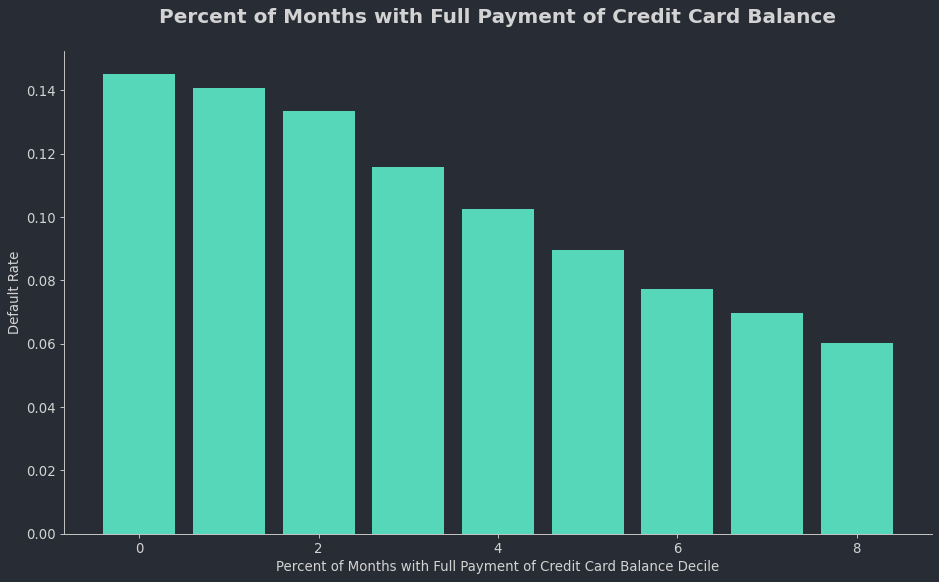

''

In [213]:
col = 'pct_full_payment'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 15, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Percent of Months with Full Payment of Credit Card Balance')




ax.set_ylabel('Default Rate')
ax.set_xlabel('Percent of Months with Full Payment of Credit Card Balance Decile')
plt.show()
;

In [214]:
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','pct_full_payment']],how='left',on='sk_id_curr')

In [215]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','pct_full_payment']],how='left',on='sk_id_curr')

In [216]:
d['application_train_df'].loc[d['application_train_df']['pct_full_payment'].isna(),'no_previous_credit_card_history_ind'].value_counts()

no_previous_credit_card_history_ind
1    218986
Name: count, dtype: int64

In [217]:
d['application_test_df'].loc[d['application_test_df']['pct_full_payment'].isna(),'no_previous_credit_card_history_ind'].value_counts()

no_previous_credit_card_history_ind
1    32091
Name: count, dtype: int64

In [218]:
d['application_train_df']['pct_full_payment'].fillna(d['application_train_df']['pct_full_payment'].mean(),inplace=True)
d['application_test_df']['pct_full_payment'].fillna(d['application_test_df']['pct_full_payment'].mean(),inplace=True)

The number of credit cards is not worth considering due to low sample of people with more than 1 credit card

In [219]:
cc_grp = d['credit_card_balance_df'].groupby('sk_id_curr').agg({'sk_id_prev':'nunique'}).rename(columns = {'sk_id_prev':'n_credit_cards'})

In [220]:
cc_grp['n_credit_cards'].value_counts()

n_credit_cards
1    102818
2       732
3         7
4         1
Name: count, dtype: int64

Percent of time the customer is past due does not have a clear correlation to future default rate and will be excluded

In [221]:
# percent of time that they are pass due
d['credit_card_balance_df']['is_past_due_1'] = np.where(d['credit_card_balance_df']['sk_dpd'] > 0,1,0)
# d['credit_card_balance_df']['is_past_due_2'] = np.where(d['credit_card_balance_df']['sk_dpd_def'] > 0,1,0)
cc_grp = d['credit_card_balance_df'].groupby('sk_id_curr').agg({'is_past_due_1':'sum','months_balance':'count'})
cc_grp['past_due_pct_1'] = cc_grp['is_past_due_1'] / cc_grp['months_balance']
# cc_grp['past_due_pct_2'] = cc_grp['is_past_due_2'] / cc_grp['months_balance']
cc_grp['past_due_pct_1_bin'] = pd.cut(cc_grp['past_due_pct_1'],bins = [-0.01,0.0001,0.2,0.4,0.6,0.8,1.0],labels = [x for x in range(1,7)])
# cc_grp['past_due_pct_2_bin'] = pd.cut(cc_grp['past_due_pct_2'],bins = [-0.01,0.0001,0.2,0.4,0.6,0.8,1.0],labels = [x for x in range(1,7)])
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/1187593544.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = cc_grp.groupby('past_due_pct_1_bin').agg({'target':'mean','months_balance':'count'})


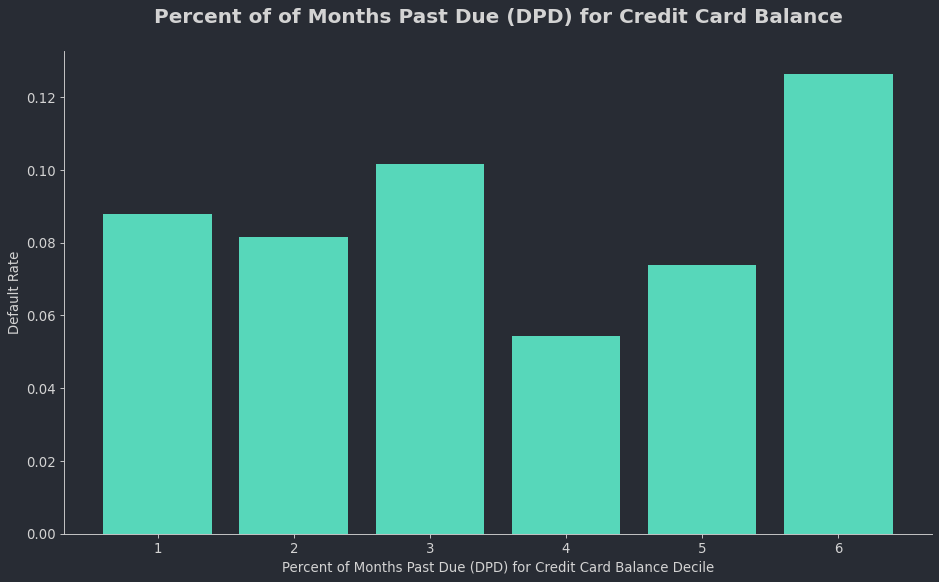

''

In [222]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = cc_grp.groupby('past_due_pct_1_bin').agg({'target':'mean','months_balance':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title("Percent of of Months Past Due (DPD) for Credit Card Balance")



ax.set_ylabel('Default Rate')
ax.set_xlabel('Percent of Months Past Due (DPD) for Credit Card Balance Decile')
plt.show()
;

# Previous Application Dataset

Next, we analyze the `previous_application_df` for features that might be useful in our modeling.

In [223]:
d['application_train_df'][d['application_train_df']['sk_id_curr'] == 100006]

,sk_id_curr,target,code_gender,flag_own_realty,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client_w_city,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,housing_pca_1,housing_pca_2,housing_pca_3,housing_pca_4,housing_pca_5,housing_pca_6,housing_pca_7,housing_pca_8,housing_pca_9,housing_pca_10,housing_pca_11,housing_pca_12,has_child,has_multiple_children,lives_alone,unknown_credit,changed_phone_day_of,null_ext_source_1,null_ext_source_3,income_to_avg_occupation_income_ratio,income_to_avg_organization_income_ratio,flag_document_sum,reg_flag_sum,obs_30_cnt_social_circle_log,def_30_cnt_social_circle_log,obs_60_cnt_social_circle_log,def_60_cnt_social_circle_log,payment_to_income_ratio,additional_credit_pct_over_price,age_years,down_payment,down_payment_pct,name_contract_type_Cash loans,name_contract_type_Revolving loans,flag_own_car_N,flag_own_car_Y,name_income_type_Commercial associate,name_income_type_Other,...,weekday_appr_process_start_SUNDAY,weekday_appr_process_start_THURSDAY,weekday_appr_process_start_TUESDAY,weekday_appr_process_start_WEDNESDAY,hour_appr_process_start_afternoon,hour_appr_process_start_early-morning,hour_appr_process_start_morning,hour_appr_process_start_night,organization_type_Advertising,organization_type_Agriculture,organization_type_Bank,organization_type_Business Entity,organization_type_Cleaning,organization_type_Construction,organization_type_Culture,organization_type_Electricity,organization_type_Emergency,organization_type_Government,organization_type_Hotel,organization_type_Housing,organization_type_Industry,organization_type_Insurance,organization_type_Kindergarten,organization_type_Legal Services,organization_type_Medicine,organization_type_Military,organization_type_Mobile,organization_type_Other,organization_type_Police,organization_type_Postal,organization_type_Realtor,organization_type_Religion,organization_type_Restaurant,organization_type_School,organization_type_Security,organization_type_Security Ministries,organization_type_Self-employed,organization_type_Services,organization_type_Telecom,organization_type_Trade,organization_type_Transport,organization_type_University,organization_type_XNA,fondkapremont_mode_missing,fondkapremont_mode_not specified,fondkapremont_mode_org spec account,fondkapremont_mode_reg oper account,fondkapremont_mode_reg oper spec account,region_0.0,region_1.0,region_10.0,region_11.0,region_12.0,region_13.0,region_14.0,region_15.0,region_16.0,region_17.0,region_18.0,region_19.0,region_2.0,region_20.0,region_21.0,region_22.0,region_23.0,region_24.0,region_25.0,region_26.0,region_27.0,region_28.0,region_29.0,region_3.0,region_30.0,region_31.0,region_32.0,region_33.0,region_34.0,region_35.0,region_36.0,region_37.0,region_38.0,region_39.0,region_4.0,region_40.0,region_41.0,region_42.0,region_43.0,region_44.0,region_45.0,region_46.0,region_5.0,region_6.0,region_7.0,region_8.0,region_9.0,region_Other,avg_credit_utilization_rate,no_previous_credit_card_history_ind,atm_per_month,pct_full_payment
3,100006,0,1,1,1350

In [224]:
d['previous_application_df'][d['previous_application_df']['sk_id_curr'] == 100006]

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
98162,2078043,100006,Cash loans,24246.00,675000.00,675000.0,NaN,675000.00,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Approved,-181,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,48.0,low_normal,Cash X-Sell: low,365243.0,-151.0,1259.0,-151.0,-143.0,0.0
617859,2827850,100006,Revolving loans,NaN,0.00,0.0,NaN,NaN,THURSDAY,15,Y,1,NaN,NaN,NaN,XAP,Canceled,-181,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
830967,2190416,100006,Consumer loans,29027.52,334917.00,267930.0,66987.00,334917.00,SUNDAY,15,Y,1,0.217830,NaN,NaN,XAP,Approved,-311,Cash through the bank,XAP,Family,Repeater,Audio/Video,POS,XNA,Country-wide,8025,Consumer electronics,12.0,high,POS household with interest,365243.0,-281.0,49.0,365243.0,365243.0,0.0
900957,1489396,100006,Revolving loans,13500.00,270000.00,270000.0,NaN,270000.00,THURSDAY,15,Y,1,NaN,NaN,NaN,XAP,Approved,-181,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
1131133,1020698,100006,Cash loans,39954.51,454500.00,481495.5,NaN,454500.00,SATURDAY,12,Y,1,NaN,NaN,NaN,XNA,Approved,-438,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,high,Cash X-Sell: high,NaN,NaN,NaN,NaN,NaN,NaN
1232752,1243599,100006,Cash loans,NaN,0.00,0.0,NaN,NaN,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-181,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1333657,2299329,100006,Consumer loans,2482.92,26912.34,24219.0,2693.34,26912.34,TUESDAY,15,Y,1,0.108994,NaN,NaN,XAP,Approved,-617,XNA,XAP,NaN,New,Construction Materials,POS,XNA,Stone,30,Construction,12.0,middle,POS industry with interest,365243.0,-545.0,-215.0,-425.0,-416.0,0.0
1595430,2545789,100006,Cash loans,NaN,0.00,0.0,NaN,NaN,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-181,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1607443,1697039,100006,Cash loans,32696.10,688500.00,906615.0,NaN,688500.00,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Refused,-181,Cash through the bank,LIMIT,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,48.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN


We engineered the following features for possible selection in our model:

* previous_rejections
* sum_previous_credit_requested
* sum_previous_credit_approved
* number_of_previous_applications

In [225]:
#d['previous_application_df']['name_cash_loan_purpose'].unique()

In [226]:
d['previous_application_df']['name_contract_status'].unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [227]:
# encode the `name_contract_status` attribute

d['previous_application_df']['name_contract_status_encode'] = [ 1 if elem == 'Refused' else 0 for elem in d['previous_application_df']['name_contract_status'] ]
d['previous_application_df'].head(3)


,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval,name_contract_status_encode
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0


In [228]:
previous_applications_enriched_df = d['previous_application_df'].groupby(['sk_id_curr']) \
                                                     .agg({
                                                           'name_contract_status_encode' : 'sum',
                                                            'amt_application' : 'sum',
                                                            'amt_credit' : 'sum',
                                                            'sk_id_prev' : 'count'
                                                      }) \
                                                      .rename(columns={'name_contract_status_encode' : 'previous_rejection',
                                                                       'amt_application' : 'sum_previous_credit_requested',
                                                                       'amt_credit' : 'sum_previous_credit_approved',
                                                                       'sk_id_prev' : 'number_of_previous_applications'
                                                      }) \
                                                      .reset_index()



# after grouping by sk_id_curr, now create an indicator for any previous rejection
previous_applications_enriched_df['previous_rejection'] = [ 1 if elem > 0 else 0 for elem in previous_applications_enriched_df['previous_rejection'] ]
previous_applications_enriched_df.head(5)

,sk_id_curr,previous_rejection,sum_previous_credit_requested,sum_previous_credit_approved,number_of_previous_applications
0,100001,0,24835.5,23787.0,1
1,100002,0,179055.0,179055.0,1
2,100003,0,1306309.5,1452573.0,3
3,100004,0,24282.0,20106.0,1
4,100005,0,44617.5,40153.5,2


Let's filter for only previous applications that were either `approved` or `refused`.

In [229]:
app_states = ['Approved', 'Refused']

previous_application_subset = d['previous_application_df'][d['previous_application_df']['name_contract_status'].isin(app_states)]
previous_application_subset.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval,name_contract_status_encode
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,1


In [230]:
d['previous_application_df']['name_contract_status'].value_counts()

name_contract_status
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64

In [231]:
previous_applications_enriched_df.loc[previous_applications_enriched_df['sum_previous_credit_requested'] == 0]

,sk_id_curr,previous_rejection,sum_previous_credit_requested,sum_previous_credit_approved,number_of_previous_applications
113,100120,0,0.0,0.0,3
347,100368,0,0.0,112500.0,4
825,100870,0,0.0,135000.0,1
1162,101216,0,0.0,112500.0,1
2109,102199,0,0.0,180000.0,1
...,...,...,...,...,...
337479,454839,0,0.0,67500.0,1
337480,454841,0,0.0,0.0,3
338605,455999,0,0.0,0.0,1
338780,456177,0,0.0,0.0,1


In [232]:
#Convert these to a log scale
previous_applications_enriched_df['sum_previous_credit_requested'] = np.log(previous_applications_enriched_df['sum_previous_credit_requested'] + 1)
previous_applications_enriched_df['sum_previous_credit_approved'] = np.log(previous_applications_enriched_df['sum_previous_credit_approved'] + 1)


In [233]:
# join the previous application data to the training dataset
d['application_train_df'] = pd.merge(d['application_train_df'], previous_applications_enriched_df, on = 'sk_id_curr', how = 'left')
d['application_test_df'] = pd.merge(d['application_test_df'], previous_applications_enriched_df, on = 'sk_id_curr', how = 'left')

In [234]:
#using intuion, we will fill nulls with 0 because if they have no previous applications, they should have 0 for all of these

d['application_train_df']['previous_rejection'].fillna(0,inplace=True)
d['application_train_df']['sum_previous_credit_requested'].fillna(0,inplace=True)
d['application_train_df']['sum_previous_credit_approved'].fillna(0,inplace=True)
d['application_train_df']['number_of_previous_applications'].fillna(0,inplace=True)

d['application_test_df']['previous_rejection'].fillna(0,inplace=True)
d['application_test_df']['sum_previous_credit_requested'].fillna(0,inplace=True)
d['application_test_df']['sum_previous_credit_approved'].fillna(0,inplace=True)
d['application_test_df']['number_of_previous_applications'].fillna(0,inplace=True)

In [235]:
temp = d['application_train_df'][['target','sum_previous_credit_requested','sum_previous_credit_approved']].copy()
temp['sum_previous_credit_requested_bin'] = pd.qcut(temp['sum_previous_credit_requested'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['sum_previous_credit_approved_bin'] = pd.qcut(temp['sum_previous_credit_approved'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/345694792.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_grp = temp.groupby('sum_previous_credit_requested_bin').agg({'target':'mean'})


''

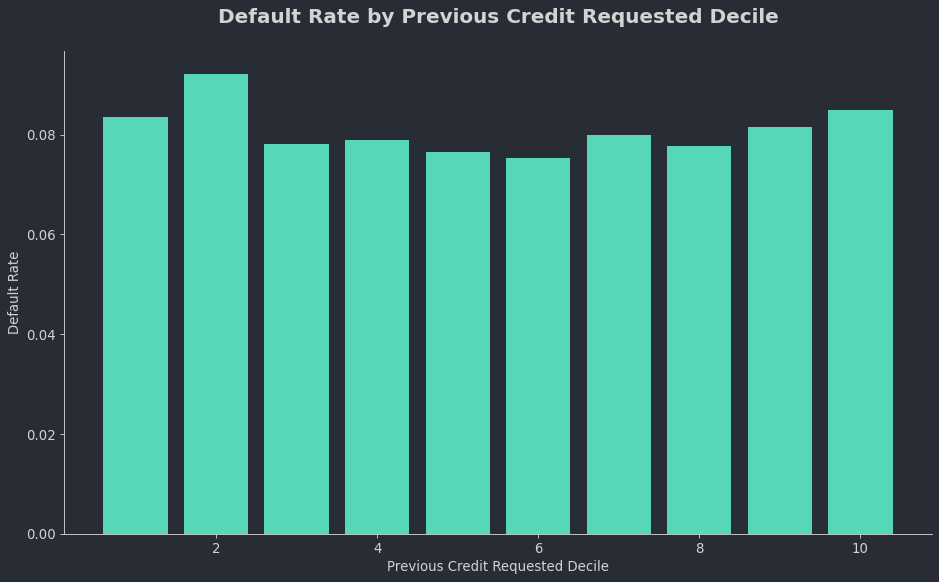

In [236]:
# Are applicants who previously requested signficant credit more likely to default?  No!
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp_grp = temp.groupby('sum_previous_credit_requested_bin').agg({'target':'mean'})

ax.bar(temp_grp.index, temp_grp['target'])

ax.set_title("Default Rate by Previous Credit Requested Decile")


# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('Previous Credit Requested Decile')

;

C:\Users\ryan\AppData\Local\Temp/ipykernel_16252/239510329.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_grp = temp.groupby('sum_previous_credit_approved_bin').agg({'target':'mean'})


Text(0.5, 0, 'Previous Credit Approved Decile')

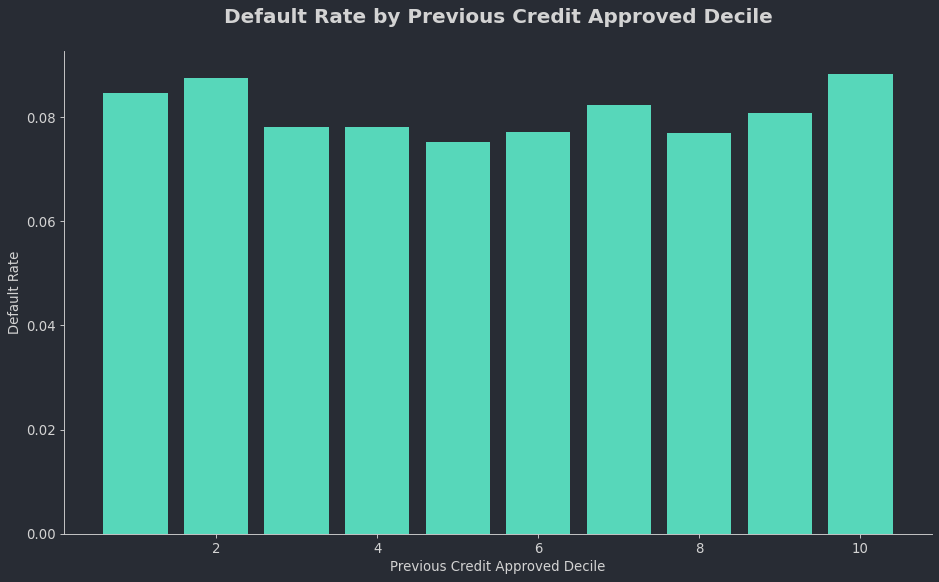

In [237]:
# Are applicants who previously were approved for signficant credit more likely to default?  No!
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp_grp = temp.groupby('sum_previous_credit_approved_bin').agg({'target':'mean'})

ax.bar(temp_grp.index, temp_grp['target'])

ax.set_title("Default Rate by Previous Credit Approved Decile")


ax.set_ylabel('Default Rate')
ax.set_xlabel('Previous Credit Approved Decile')

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


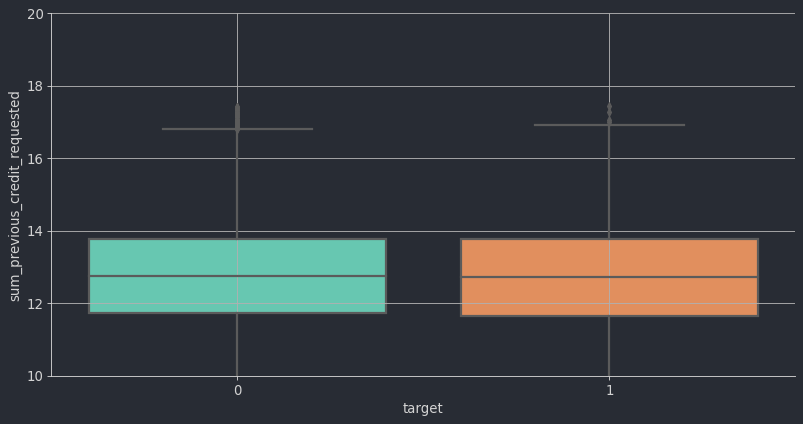

In [238]:

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'sum_previous_credit_requested')
plt.grid()

plt.ylim(10,20)


plt.show()

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


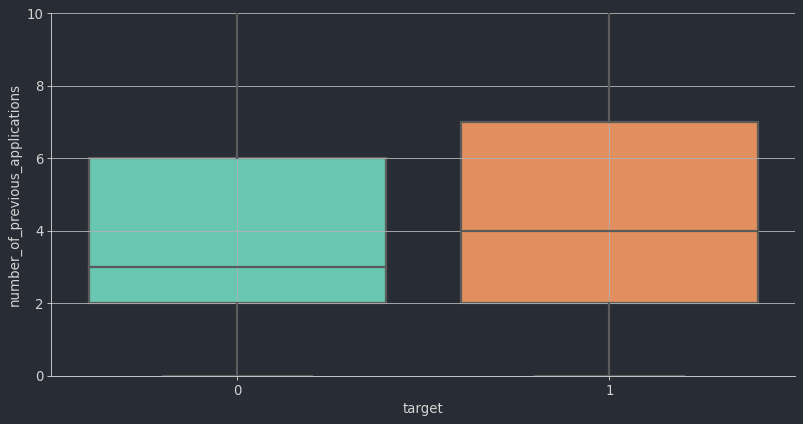

In [239]:
# Is the number of previous applications correlated with default?  Possibly...

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'number_of_previous_applications')
plt.ylim(0,10)
plt.grid()

plt.show()

In [240]:
#memory management b/c this was a copy
temp.drop(temp.index,inplace=True)
del temp

In [241]:
# Are borrowers who have previously been rejected more likely to default? Yes!

previous_rejection_target_counts = d['application_train_df'].groupby(['previous_rejection', 'target']).size()

previous_rejection_target_counts_unstacked = previous_rejection_target_counts.unstack('target')

percentage_defaults_by_previous_rejection = previous_rejection_target_counts_unstacked.div(previous_rejection_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_previous_rejection)

target                      0          1
previous_rejection                      
0.0                 92.998791   7.001209
1.0                 89.671906  10.328094


In [244]:
pd.set_option('display.max_rows', 400)
d['application_train_df'].isna().sum()

sk_id_curr                                           0
target                                               0
code_gender                                          0
flag_own_realty                                      0
amt_income_total                                     0
amt_credit                                           0
amt_annuity                                          0
amt_goods_price                                      0
region_population_relative                           0
days_birth                                           0
days_employed                                        0
days_registration                                    0
days_id_publish                                      0
own_car_age                                          0
flag_mobil                                           0
flag_emp_phone                                       0
flag_work_phone                                      0
flag_cont_mobile                                     0
flag_phone

In [245]:
d['application_test_df'].isna().sum()

sk_id_curr                                           0
code_gender                                          0
flag_own_realty                                      0
amt_income_total                                     0
amt_credit                                           0
amt_annuity                                          0
amt_goods_price                                      0
region_population_relative                           0
days_birth                                           0
days_employed                                        0
days_registration                                    0
days_id_publish                                      0
own_car_age                                          0
flag_mobil                                           0
flag_emp_phone                                       0
flag_work_phone                                      0
flag_cont_mobile                                     0
flag_phone                                           0
flag_email

In [246]:
pd.set_option('display.max_rows', 50)

In [247]:
d['application_train_df'].info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305834 entries, 0 to 305833
Data columns (total 247 columns):
 #    Column                                             Non-Null Count   Dtype  
---   ------                                             --------------   -----  
 0    sk_id_curr                                         305834 non-null  int64  
 1    target                                             305834 non-null  int64  
 2    code_gender                                        305834 non-null  int32  
 3    flag_own_realty                                    305834 non-null  int32  
 4    amt_income_total                                   305834 non-null  float64
 5    amt_credit                                         305834 non-null  float64
 6    amt_annuity                                        305834 non-null  float64
 7    amt_goods_price                                    305834 non-null  float64
 8    region_population_relative                         305834 non-

#Machine Learning Modeling

In this section, we build and train the following supervised machine learning models:

* logistic regression
* random forest
* gradient boosted trees
* neural networks

In [248]:
#clearing memory
for col in ['credit_card_balance_df','previous_application_df']: #'installments_payments_df','pos_cash_balance_df'
    d[col].drop(d[col].index,inplace=True)
    del d[col]

In [249]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

   previous_application_subset:  1.5 GiB
                          _174: 462.1 MiB
             app_train_housing: 143.1 MiB
             X_train_resampled: 36.2 MiB
                       X_train: 17.7 MiB
              X_test_resampled: 15.5 MiB
previous_applications_enriched_df: 12.9 MiB
                        X_test:  7.6 MiB
                        cc_grp:  3.7 MiB
             y_train_resampled:  3.0 MiB


In [250]:
#if these are still loaded in memory, delete them (just using del just deletes the immediate reference, so dropping rows first is necessary)
try:
    previous_application_subset.drop(previous_application_subset.index,inplace=True)
    del previous_application_subset
except:
    pass
try:
    if df:
        df.drop(df.index,inplace=True)
        del df
except:
    pass

## Logistic Regression

In [251]:
# Create our X and y datasets

X = d['application_train_df'].drop('target', axis = 1)
X.head()

,sk_id_curr,code_gender,flag_own_realty,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client_w_city,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,housing_pca_1,housing_pca_2,housing_pca_3,housing_pca_4,housing_pca_5,housing_pca_6,housing_pca_7,housing_pca_8,housing_pca_9,housing_pca_10,housing_pca_11,housing_pca_12,has_child,has_multiple_children,lives_alone,unknown_credit,changed_phone_day_of,null_ext_source_1,null_ext_source_3,income_to_avg_occupation_income_ratio,income_to_avg_organization_income_ratio,flag_document_sum,reg_flag_sum,obs_30_cnt_social_circle_log,def_30_cnt_social_circle_log,obs_60_cnt_social_circle_log,def_60_cnt_social_circle_log,payment_to_income_ratio,additional_credit_pct_over_price,age_years,down_payment,down_payment_pct,name_contract_type_Cash loans,name_contract_type_Revolving loans,flag_own_car_N,flag_own_car_Y,name_income_type_Commercial associate,name_income_type_Other,name_income_type_Pensioner,...,hour_appr_process_start_afternoon,hour_appr_process_start_early-morning,hour_appr_process_start_morning,hour_appr_process_start_night,organization_type_Advertising,organization_type_Agriculture,organization_type_Bank,organization_type_Business Entity,organization_type_Cleaning,organization_type_Construction,organization_type_Culture,organization_type_Electricity,organization_type_Emergency,organization_type_Government,organization_type_Hotel,organization_type_Housing,organization_type_Industry,organization_type_Insurance,organization_type_Kindergarten,organization_type_Legal Services,organization_type_Medicine,organization_type_Military,organization_type_Mobile,organization_type_Other,organization_type_Police,organization_type_Postal,organization_type_Realtor,organization_type_Religion,organization_type_Restaurant,organization_type_School,organization_type_Security,organization_type_Security Ministries,organization_type_Self-employed,organization_type_Services,organization_type_Telecom,organization_type_Trade,organization_type_Transport,organization_type_University,organization_type_XNA,fondkapremont_mode_missing,fondkapremont_mode_not specified,fondkapremont_mode_org spec account,fondkapremont_mode_reg oper account,fondkapremont_mode_reg oper spec account,region_0.0,region_1.0,region_10.0,region_11.0,region_12.0,region_13.0,region_14.0,region_15.0,region_16.0,region_17.0,region_18.0,region_19.0,region_2.0,region_20.0,region_21.0,region_22.0,region_23.0,region_24.0,region_25.0,region_26.0,region_27.0,region_28.0,region_29.0,region_3.0,region_30.0,region_31.0,region_32.0,region_33.0,region_34.0,region_35.0,region_36.0,region_37.0,region_38.0,region_39.0,region_4.0,region_40.0,region_41.0,region_42.0,region_43.0,region_44.0,region_45.0,region_46.0,region_5.0,region_6.0,region_7.0,region_8.0,region_9.0,region_Other,avg_credit_utilization_rate,no_previous_credit_card_history_ind,atm_per_month,pct_full_payment,previous_rejection,sum_previous_credit_requested,sum_previous_credit_approved,number_of_previous_applications
0,100002,0,1,202500.0,406597.5,

In [252]:
y = d['application_train_df']['target']
y.head()

0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [253]:
random_state = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

In [254]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit(X_train).transform(X_test)

X_train_scaled_resampled, y_train_scaled_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train_scaled, y_train)
#don't oversample the test set
# X_test_scaled_resampled, y_test_scaled_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test_scaled, y_test)

In [255]:
# get these optimized parameters from Grid Search (see below)
optimized_C = 10
optimized_penalty = 'l2'

logistic_regression_model = LogisticRegression(max_iter = 10_000, C = optimized_C, penalty = optimized_penalty)
logistic_regression_model.fit(X_train_scaled_resampled, y_train_scaled_resampled)
#if not lr_model.converged_:
#  print('The model did not converge.')


LogisticRegression(C=10, max_iter=10000)

In [256]:
# make predictions from the test data
y_pred = logistic_regression_model.predict(X_test_scaled)


In [257]:
accuracy = logistic_regression_model.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')


The accuracy is: 69.60%


In [258]:
# get the confusion matrix

confusion_matrix(y_test, y_pred)


array([[39150, 17053],
       [ 1544,  3420]], dtype=int64)

In [259]:
# get the accuracy, precision, recall and F1 scores

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')


Accuracy: 69.60%
Precision: 16.70%
Recall: 68.90%
F1: 26.89%


In [260]:
# plot the ROC curve

y_proba = logistic_regression_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7595235846664568


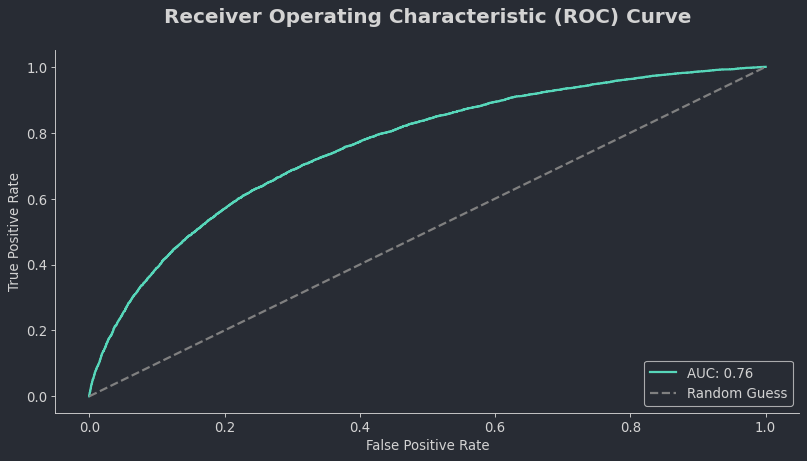

In [261]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Logistic Regression with PCA

In [262]:
pca = PCA(n_components = X_train_scaled[0].size)
pca.fit(X_train_scaled)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

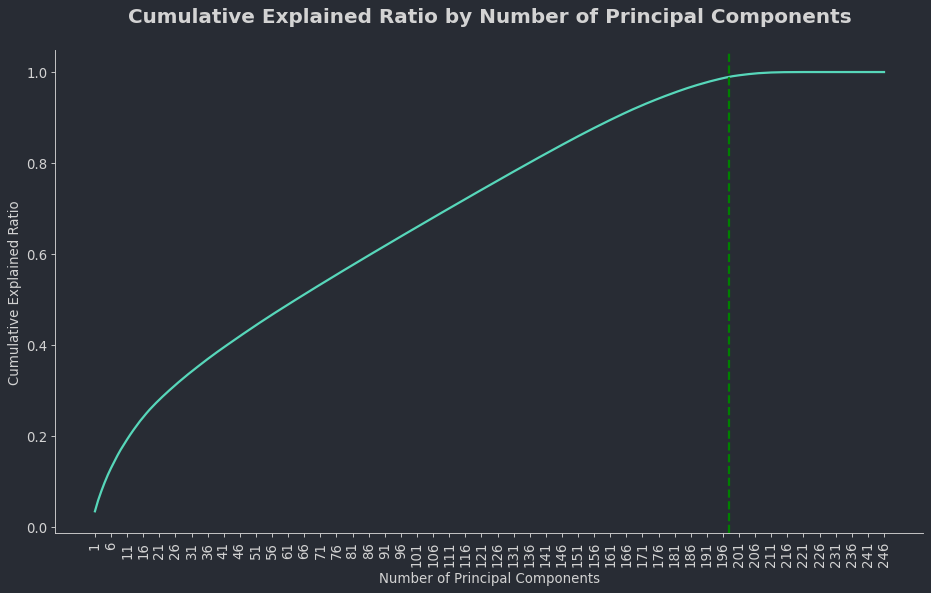

In [263]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.plot(cum_evr)
ax.set_xticks(np.arange(0, X_train_scaled[0].size, 5))
ax.set_xticklabels(np.arange(0, X_train_scaled[0].size, 5) + 1, rotation = 90)

ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Ratio')
ax.set_title('Cumulative Explained Ratio by Number of Principal Components')

#Vertical Line here at 11 really means 12 components
ax.axvline(197, linestyle = '--', color='green')

plt.show()

In [264]:
"{:.2%}".format(cum_evr[197]) #note that 197 is the 198 component

'98.96%'

In [265]:
pca = PCA(n_components = 197)
pca.fit(X_train_scaled)

PCA(n_components=197)

In [266]:
X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

In [267]:
#really no need to reassign y_train here b/c the seed is the same
X_train_PCA_resampled, y_train_PCA_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train_PCA, y_train)

In [268]:
optimized_C = 10
optimized_penalty = 'l2'

logistic_regression_model = LogisticRegression(max_iter = 10_000, C = optimized_C, penalty = optimized_penalty)
logistic_regression_model.fit(X_train_PCA_resampled, y_train_PCA_resampled)

LogisticRegression(C=10, max_iter=10000)

In [269]:
y_pred = logistic_regression_model.predict(X_test_PCA)

In [270]:
# get the confusion matrix

confusion_matrix(y_test, y_pred)

array([[39085, 17118],
       [ 1547,  3417]], dtype=int64)

In [271]:
#PCA resulted in a slight dip in accuracy
# get the accuracy, precision, recall and F1 scores

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')

Accuracy: 69.49%
Precision: 16.64%
Recall: 68.84%
F1: 26.80%


In [272]:
# plot the ROC curve

y_proba = logistic_regression_model.predict_proba(X_test_PCA)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7554723170753057


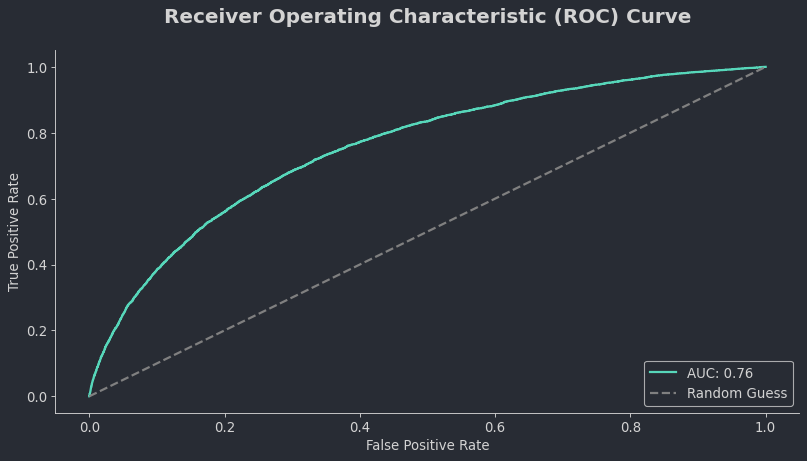

In [273]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Decision Trees

In [274]:
# create the decision tree classifier
clf_tree = DecisionTreeClassifier(random_state = 42, max_depth = 10,min_samples_split= 50)


In [275]:
# fit the model to the training data

clf_tree.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_tree.predict(X_test_scaled)

In [276]:
accuracy = clf_tree.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 64.39%


In [277]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.64      0.77     56203
           1       0.14      0.66      0.23      4964

    accuracy                           0.64     61167
   macro avg       0.55      0.65      0.50     61167
weighted avg       0.89      0.64      0.72     61167



In [278]:
confusion_matrix(y_test, y_pred)


array([[36095, 20108],
       [ 1675,  3289]], dtype=int64)

In [279]:
# plot the ROC curve

y_proba = clf_tree.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.6960096395988737


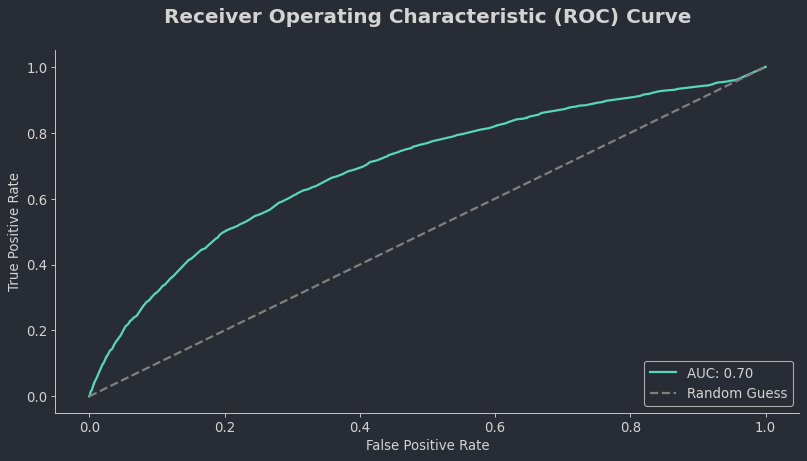

In [280]:

plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Random Forest

In [281]:
# create the random forest classifier
clf_random_forest = RandomForestClassifier(random_state = 42,max_depth = 10)

In [282]:
# fit the model to the training data

clf_random_forest.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_random_forest.predict(X_test_scaled)


In [283]:
accuracy = clf_random_forest.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 71.57%


In [284]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56203
           1       0.17      0.64      0.27      4964

    accuracy                           0.72     61167
   macro avg       0.56      0.68      0.55     61167
weighted avg       0.89      0.72      0.78     61167



In [285]:
confusion_matrix(y_test, y_pred)

array([[40618, 15585],
       [ 1804,  3160]], dtype=int64)

In [286]:
# plot the ROC curve

y_proba = clf_random_forest.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7441287642357466


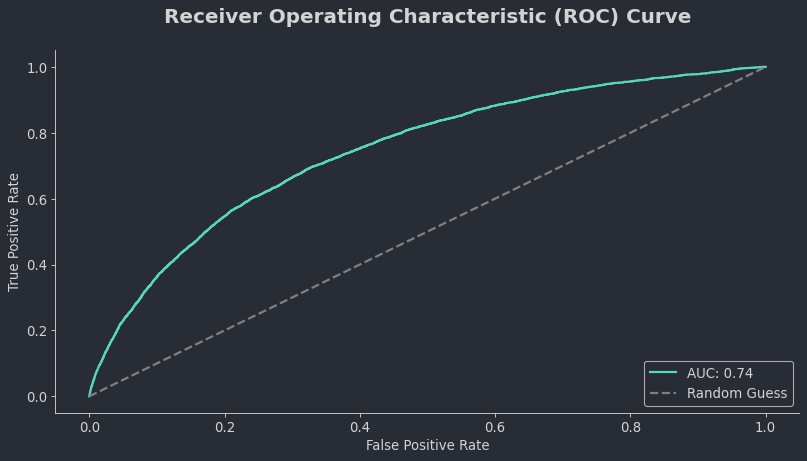

In [287]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [288]:
# memory cleanup
#del clf_random_forest
#del clf_tree

## Gradient Boosting

In [289]:
# create the gradient boost classifier
clf_gradient_boost = GradientBoostingClassifier(random_state = 42)


In [290]:
# fit the model to the training data

clf_gradient_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_gradient_boost.predict(X_test_scaled)

In [291]:
accuracy = clf_gradient_boost.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 69.86%


In [292]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56203
           1       0.17      0.69      0.27      4964

    accuracy                           0.70     61167
   macro avg       0.57      0.70      0.54     61167
weighted avg       0.90      0.70      0.77     61167



In [293]:
confusion_matrix(y_test, y_pred)

array([[39301, 16902],
       [ 1533,  3431]], dtype=int64)

In [294]:
# plot the ROC curve

y_proba = clf_gradient_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7620418782936373


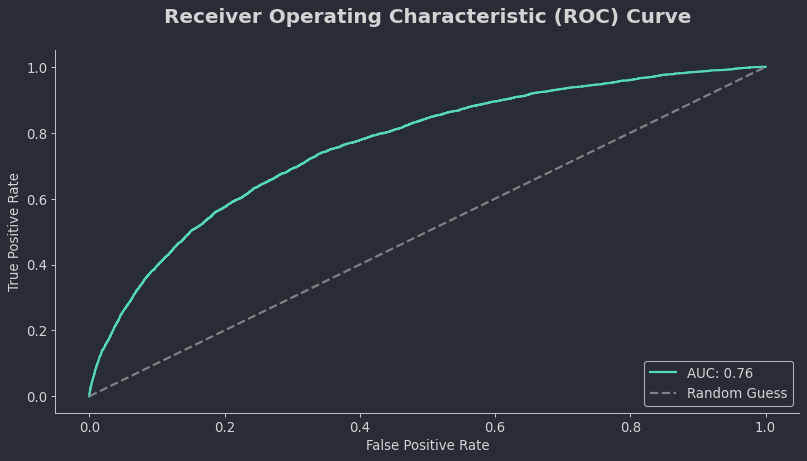

In [295]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## XG Boost

In [296]:
# create the gradient boost classifier
clf_xg_boost = XGBClassifier(random_state = 42)


In [297]:
# fit the model to the training data

clf_xg_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_xg_boost.predict(X_test_scaled)

In [298]:
accuracy = clf_xg_boost.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 74.50%


In [299]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.76      0.85     56203
           1       0.18      0.61      0.28      4964

    accuracy                           0.75     61167
   macro avg       0.57      0.68      0.56     61167
weighted avg       0.89      0.75      0.80     61167



In [300]:
confusion_matrix(y_test, y_pred)


array([[42559, 13644],
       [ 1953,  3011]], dtype=int64)

In [301]:
# plot the ROC curve

y_proba = clf_xg_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


0.751073754196236


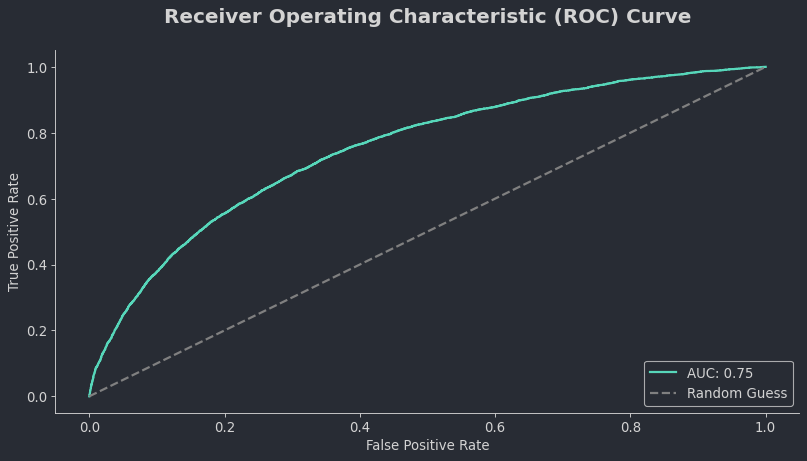

In [302]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Link to our Kaggle submission: https://prnt.sc/iP9JpvCr8uxp

Private Score: 0.73374
<br>
Public Score: 0.73328

## XGBoost with PCA

PCA showed decreased model performance.

In [303]:
clf_xg_boost = XGBClassifier(random_state = 42,
                             )
clf_xg_boost.fit(X_train_PCA_resampled, y_train_PCA_resampled)
y_pred = clf_xg_boost.predict(X_test_PCA)

In [304]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.79      0.86     56203
           1       0.18      0.50      0.26      4964

    accuracy                           0.77     61167
   macro avg       0.56      0.65      0.56     61167
weighted avg       0.88      0.77      0.81     61167



In [305]:
confusion_matrix(y_test, y_pred)

array([[44494, 11709],
       [ 2464,  2500]], dtype=int64)

In [306]:

y_proba = clf_xg_boost.predict_proba(X_test_PCA)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


0.7112107822192784


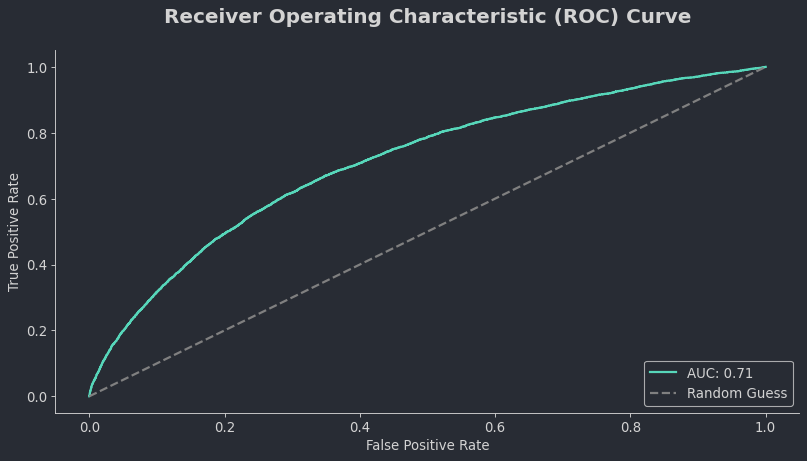

In [307]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Parameter Hypertuning


NOTE:  this took 27 hours on a GTX 1080, therefore the `fit()` line is commented out so it is not mistakenly run. The logs can be found in the accompanying .txt file named `hypertuning_logs.txt`.

In [308]:
pipeline = Pipeline([
    ('classifier', XGBClassifier(device = 'cuda'))
])
param_grid = {

    'classifier__max_depth' : [6,10,14],
    'classifier__n_estimators' : [100,500,1000],
    'classifier__learning_rate' : [0.05,0.1,0.2,0.3],
    'classifier__reg_alpha' : [0,0.5,1],
    'classifier__reg_lambda' : [0,0.5,1],
    'classifier__max_leaves' : [0,30,60,90],
    'classifier__device':['cuda']
}
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'roc_auc',verbose = 3)

In [309]:
#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

In [310]:
#results of the grid search
best_params = {'classifier__device': 'cuda',
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 14,
 'classifier__max_leaves': 0,
 'classifier__n_estimators': 1000,
 'classifier__reg_alpha': 1,
 'classifier__reg_lambda': 0.5}
best_params

{'classifier__device': 'cuda',
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 14,
 'classifier__max_leaves': 0,
 'classifier__n_estimators': 1000,
 'classifier__reg_alpha': 1,
 'classifier__reg_lambda': 0.5}

In [312]:
#read the local .txt file "hypertuning_logs" to the variable hypertuning_logs
with open('hypertuning_logs.txt', 'r') as f:
    hypertuning_logs = f.readlines()

In [313]:
hypertuning_results = []
for line in hypertuning_logs[1:]:
    rows = line.split(' ')
    
    for row in rows:
        if 'classifier__learning_rate' in row:
            learning_rate = float(row.split('=')[1].split(',')[0])
        if 'classifier__max_depth' in row:
            max_depth = int(row.split('=')[1].split(',')[0])
        if 'classifier__max_leaves' in row:
            max_leaves = int(row.split('=')[1].split(',')[0])
        if 'classifier__n_estimators' in row:
            n_estimators = int(row.split('=')[1].split(',')[0])
        if 'classifier__reg_alpha' in row:
            reg_alpha = float(row.split('=')[1].split(',')[0])
        if 'classifier__reg_lambda' in row:
            reg_lambda = float(row.split('=')[1].split(';')[0])
        if 'score' in row:
            score = float(row.split('=')[1])
            hypertuning_results.append([learning_rate,max_depth,max_leaves,n_estimators,reg_alpha,reg_lambda,score])

In [314]:
hypertuning_results = pd.DataFrame(hypertuning_results,columns = ['learning_rate','max_depth','max_leaves','n_estimators','reg_alpha','reg_lambda','score'])

In [315]:
# because there are 5 scores for each combination, we take the mean (1 for each fold)
hypertuning_results = hypertuning_results.groupby(['learning_rate','max_depth','max_leaves','n_estimators','reg_alpha','reg_lambda']).agg({'score':'mean'}).reset_index()

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


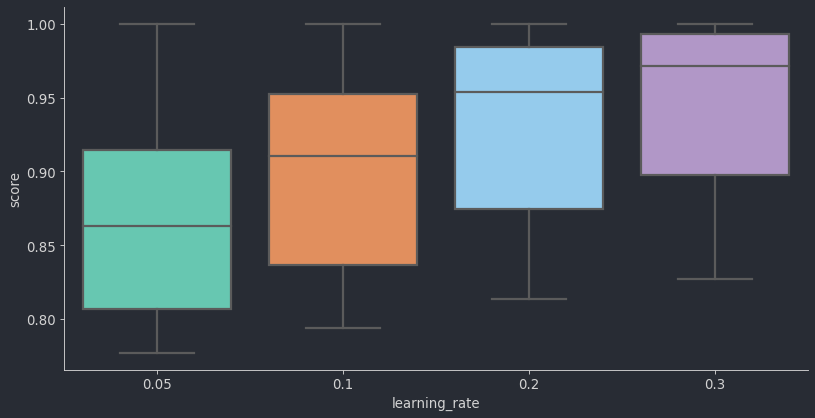

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


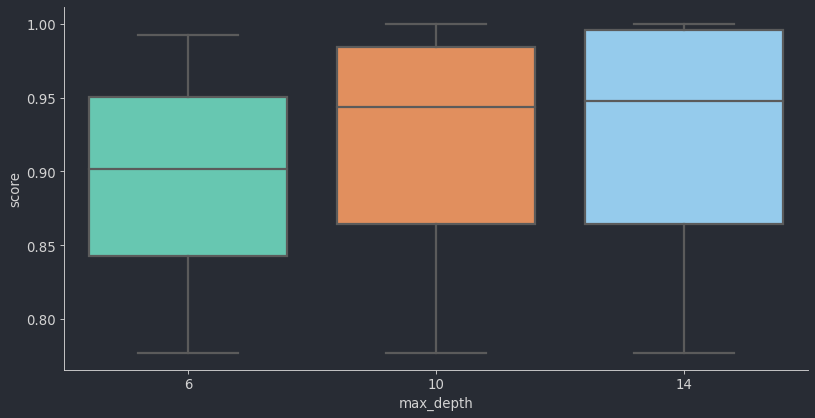

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


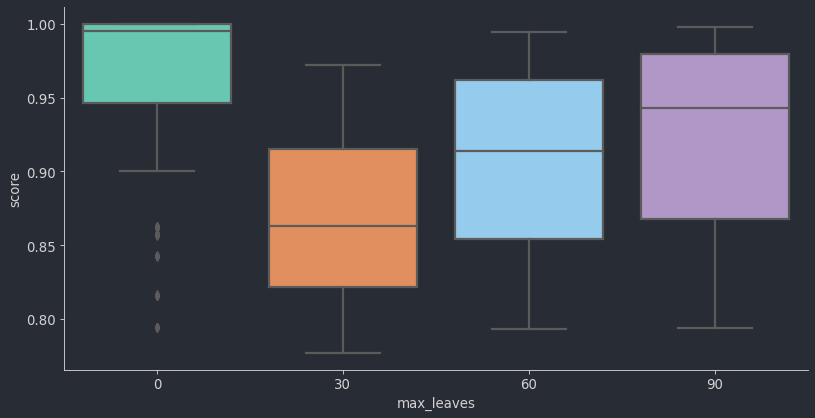

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


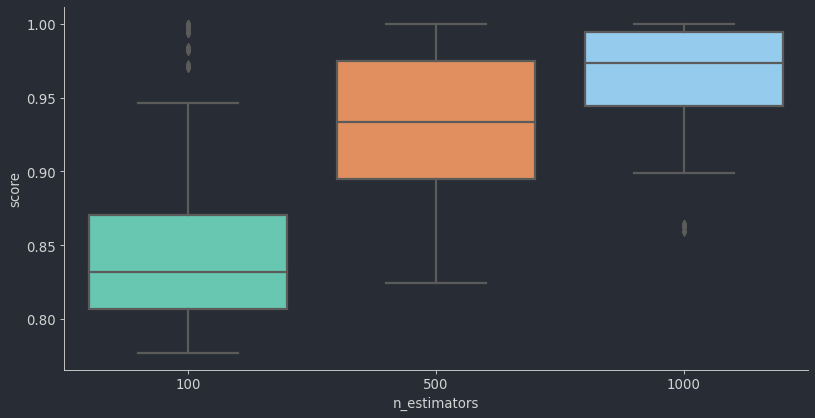

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


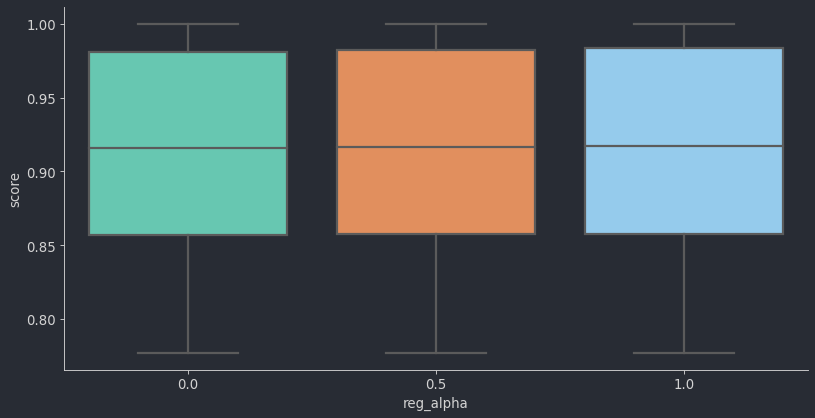

C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ryan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


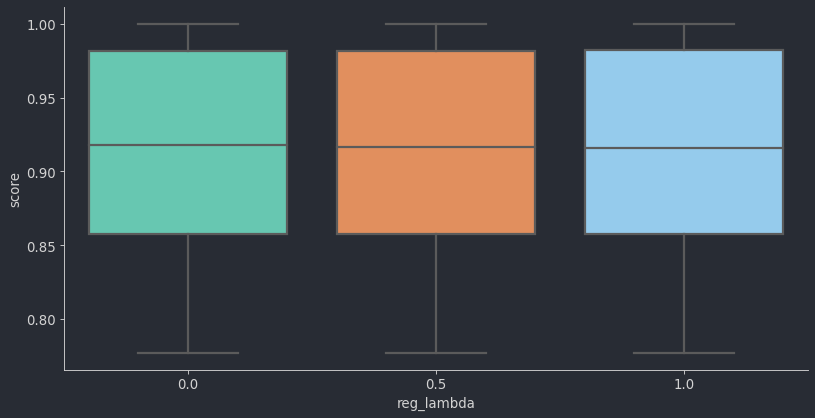

In [316]:
for col in hypertuning_results.columns:
    if col != 'score':
        sns.boxplot(data = hypertuning_results, x = col, y = 'score')
        plt.show()

In [317]:
# Running XGBoost with the Hypertuned Parameters
clf_xg_boost = XGBClassifier(random_state = 42,
                             n_estimators = 1000,
                             max_depth = 14,
                             max_leaves = 0,
                             learning_rate = 0.10,
                             reg_lambda = 1,
                             reg_alpha = 0.5,
                             device = 'cuda'
                             )
clf_xg_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_xg_boost.predict(X_test_scaled)
accuracy = clf_xg_boost.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# plot the ROC curve

y_proba = clf_xg_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


C:\Users\ryan\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


The accuracy is: 91.61%
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56203
           1       0.39      0.06      0.11      4964

    accuracy                           0.92     61167
   macro avg       0.66      0.53      0.53     61167
weighted avg       0.88      0.92      0.89     61167

[[55718   485]
 [ 4648   316]]
0.739244679730463


The hypertuned parameters decreased model performance in terms of AUC. The results may be overfit, potentially because the oversampling was performed beforehand and not as part of the pipeline. The model incorrectly predicts defaults the majority of its predictions.

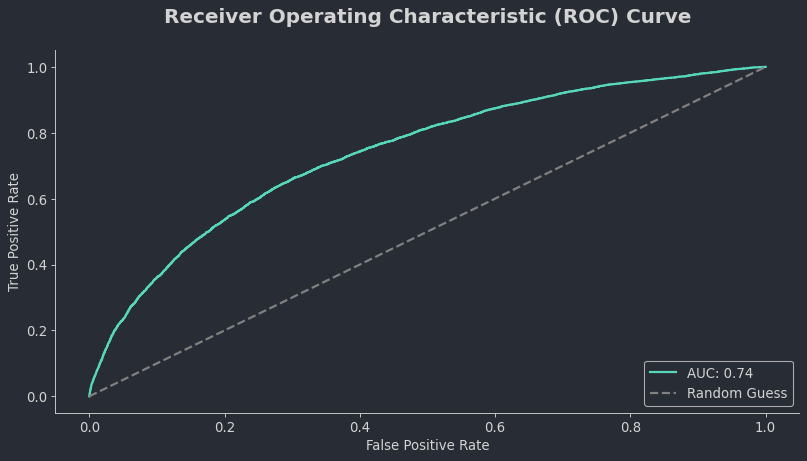

In [318]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# submit = pd.DataFrame(d['application_test_df']['sk_id_curr'])
# submit.columns = ['SK_ID_CURR']
# submit_X_scaled = StandardScaler().fit(X).transform(d['application_test_df'])
# submit['TARGET'] = clf_xg_boost.predict_proba(submit_X_scaled)[:, 1]
# submit.to_csv('submission_xgboost_optimized_parameters.csv', index = False)

Link to Kaggle submission: https://prnt.sc/IcEyl_UgcpgH

Private Score: 0.7028

Public Score: 0.71601

Lets try the hypertuned parameters again but with limited `max depth` and `max leaves`.

In [319]:
clf_xg_boost = XGBClassifier(random_state = 42,
                             n_estimators = 1000,
                             max_depth = 10,
                             learning_rate = 0.1,
                             max_leaves = 60,
                            reg_lambda = 1,
                             reg_alpha = 0.5,
                             device = 'cuda'
                             )
clf_xg_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_xg_boost.predict(X_test_scaled)
accuracy = clf_xg_boost.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# plot the ROC curve

y_proba = clf_xg_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


C:\Users\ryan\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


The accuracy is: 82.02%
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     56203
           1       0.21      0.46      0.29      4964

    accuracy                           0.82     61167
   macro avg       0.58      0.65      0.59     61167
weighted avg       0.89      0.82      0.85     61167

[[47903  8300]
 [ 2699  2265]]
0.741170102656677


For predicted defaults, it is not correct 50% of the time, so it is much less overfit. But, we are better off using the default parameters rather than these.

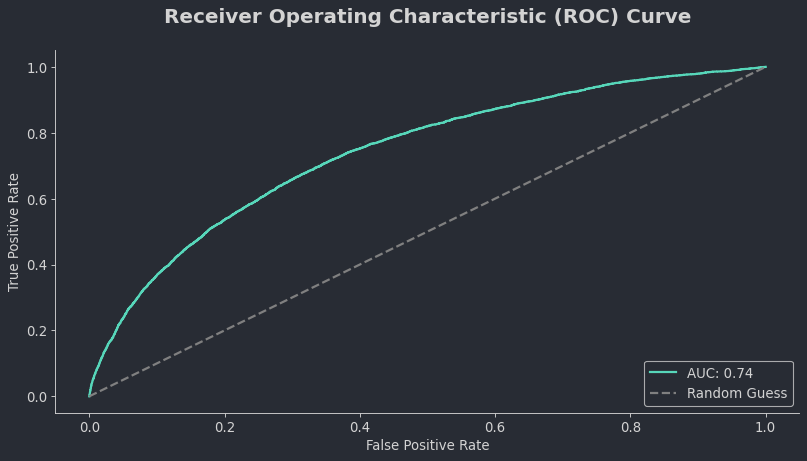

In [320]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# submit = pd.DataFrame(d['application_test_df']['sk_id_curr'])
# submit.columns = ['SK_ID_CURR']
# submit_X_scaled = StandardScaler().fit(X).transform(d['application_test_df'])
# submit['TARGET'] = clf_xg_boost.predict_proba(submit_X_scaled)[:, 1]
# submit.to_csv('submission_xgboost_optimized_parameters_override_max_depth_and_max_leaves.csv', index = False)

Link to Kaggle submission: https://prnt.sc/b3GtzOxiBYD5

Private Score: 0.71413

Public Score: 0.70395

Because the Logistic Regression performed surprisingly close to Boosting and other more sophisticated models, we opted to use Logistic Regression with Bagging as our final model. In the end, this model had the highest score for any of our models on Kaggle as well.

In [321]:
optimized_C = 10
optimized_penalty = 'l2'

logistic_regression_model = LogisticRegression(max_iter = 50_000, C = optimized_C, penalty = optimized_penalty)

In [322]:
bag = BaggingClassifier(estimator = logistic_regression_model, 
                        n_estimators = 250, 
                        random_state = 42,
                        max_samples = 1.0, 
                        max_features = 1.0, 
                        bootstrap = True, 
                        bootstrap_features = False, 
                        n_jobs = -1,
                        verbose = 3
                        )

In [ ]:
#bag.fit(X_train_scaled_resampled, y_train_scaled_resampled)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed: 151.1min remaining: 302.2min
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed: 153.2min remaining: 51.1min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed: 154.4min finished


BaggingClassifier(estimator=LogisticRegression(C=10, max_iter=50000),
                  n_estimators=250, n_jobs=-1, random_state=42, verbose=3)

In [324]:
# Because it takes a very long time for the bagging logistic regression to run, 
# we have saved it as a pickle file and will load it in here
import pickle
bag = pickle.load(open('bag_logistic_regression.sav', 'rb'))

In [325]:
y_pred = bag.predict(X_test_scaled)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.4s finished


In [326]:
confusion_matrix(y_test, y_pred)

array([[39141, 17062],
       [ 1541,  3423]], dtype=int64)

In [327]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')

Accuracy: 69.59%
Precision: 16.71%
Recall: 68.96%
F1: 26.90%


In [328]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56203
           1       0.17      0.69      0.27      4964

    accuracy                           0.70     61167
   macro avg       0.56      0.69      0.54     61167
weighted avg       0.90      0.70      0.76     61167



In [329]:
# plot the ROC curve

y_proba = bag.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.0s finished


0.7595419006240515


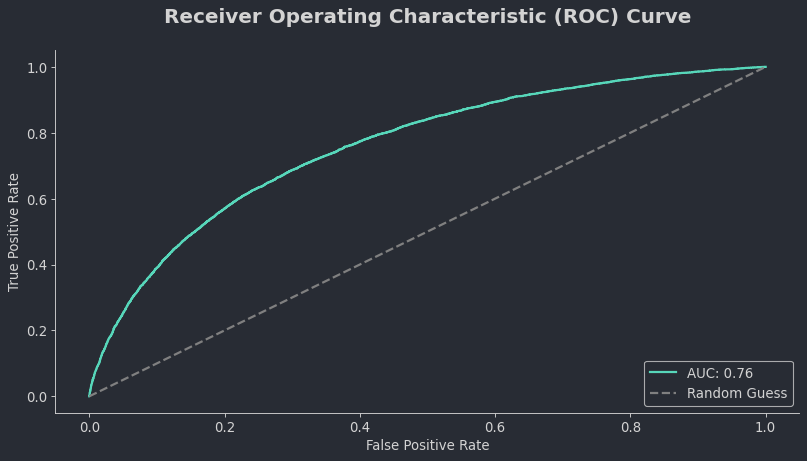

In [330]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# submit = pd.DataFrame(d['application_test_df']['sk_id_curr'])
# submit.columns = ['SK_ID_CURR']
# submit_X_scaled = StandardScaler().fit(X).transform(d['application_test_df'])
# submit['TARGET'] = bag.predict_proba(submit_X_scaled)[:, 1]
# submit.to_csv('submission_bagged_logistic_regression.csv', index = False)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:    4.1s remaining:    8.2s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:    4.4s remaining:    1.4s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    4.5s finished


Link to Kaggle submission: https://prnt.sc/jUpC7ULomLSV

Private Score: 0.74728

Public Score: 0.75295

# Challenges and Obstacles

The biggest challenge we faced during this project was the time that it took to train the various models.  In one case, the model took nearly 27 hours to train.

Additionally, we found the memory on Google Colab to be somewhat limiting.  This required us to run everything locally.

Otherwise, this was a smooth project.

# Potential Next Steps / Future Direction

Many of the stages of the machine learning workflow in this project were manual.  We would use automated machine learning (AutoML) to make all stages more efficient - from data preprocessing to feature selection and hyperparameter tuning.

Additionally, we would include the oversampling step in the grid search pipeline.  With oversampling outside the pipeline, our model was somewhat overfit.  Unfortunately, due to the time that it takes to re-train the models, we did not have time to do this and would certainly do so in a future iteration of this project.

# GitHub Repository

The commit history can be found at https://github.com/rca-devs/CIS-5450.

# Conclusion

Logistic regression with bagging was our final model.  This model performed best when run locally, as well as when submitted to Kaggle.  We very much enjoyed working on this project and felt that it nicely tied together many of the learnings of this course.

Thank you for taking the time to peruse our notebook!